# 对单摆问题的一般性讨论 General Discussion of Pendulums

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time
plt.style.use('bmh')
figsize = (12, 5)
dpi = 600

## Part1 理想单摆 The Simple Pendulums

理想单摆，是对实际的单摆模型进行理想化近似得到的结果，物理图像如图所示：
<img style="float: middle;" src="1-2.png" width="22%"> 

理想单摆模型的构建使用了模型近似，可以考虑如下的近似条件：
1. 角度近似：摆动角度很小；
2. 悬绳近似：a.轻绳；b.软绳；c.非弹性绳子
3. 重物近似：a.质点近似；b.质量固定
4. 外力近似：a.没有阻尼；b.没有惯性力；

按照四个角度，总共可以考虑8条近似条件  
这里需要指出，我们不考虑单摆初速度，或者说默认初速度为零这个条件，是因为可以将含初速度问题视为无初速度问题的一个过程解，所以单独讨论初速度就没有什么意义了；

回到理想单摆，由于有如上的近似条件，结合牛顿第二定律，可以给出运动的动力学方程：
<img style="float: middle;" src="1-1.png" width="22%">

考虑初值条件，和理想近似结果，可以化简微分方程：
<img style="float: middle;" src="1-3.png" width="16%">
用简单的积分就可以得到结果：
<img style="float: middle;" src="1-4.png" width="20%">
其中考虑初值条件，并引入角频率：
<img style="float: middle;" src="1-5.png" width="11%">

根据微分方程，我们可以利用龙格-库塔法（Runge-Kutta）法，对方程进行数值解：  
（说明：对于理想的单摆模型这里已经给出解析解结果了，但是为了方便后续讨论实际的单摆情况，还是需要进行数值模拟）

### 1.1 参数定义和说明：

a.单摆上的参数：

In [2]:
global L                      #m 单摆的摆长
L = 10
global g                      #m/s^2 重力加速度
g = 10
global fw                     #rad/s 摆动频率
fw = np.sqrt(g/L)

b.单摆运动的过程参数：

In [3]:
global t                      #单摆运动的时间 s
t = np.arange(0,10,0.01)
global w0                     #单摆运动的初始角速度 rad/s
w0 = 0
global W                      #单摆运动的角速度集合 rad/s
W = [w0]
global a0                     #单摆的摆动初始角度 rad
a0 = (5/180)*np.pi
global A                      #单摆的摆动角度集合 rad
A = [a0]

### 1.2 数值解法

本次数值模拟采用了模拟结果非常准确的四阶龙格-库塔法（4th order Runge-Kutta Method）  
利用四阶龙格库塔法解决单摆问题，目前没有太多的资源与尝试结果，此次尝试弥补了这个空缺  
本文的代码可以为学习力学和计算物理的本科生提供案例和帮助  

由于四阶龙格-库塔法一般是用于求解一阶非线性微分方程的工具  
而单摆的方程是二阶方程，故需要将方程分解为两个一阶方程求解，如下所示：
<img style="float: middle;" src="1-6.png" width="20%">

In [4]:
#先定义初始函数，这里dw就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
# code by bear

def dw(a,w,_t):
    return ( -g * a / L )

#定义RK函数，这个函数就是为了利用四阶龙格-库塔法解决单摆的问题而设计的

def RK_1(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        k11 = _w
        k21 = dw(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dw(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dw(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dw(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

### 1.3 结果输出

根据上述的解析模拟，应用上述函数，只需要把函数的参数输入到需要计算的步骤中就好，如下所示：

In [5]:
#取初始条件为开始设置的初始条件，dt步长取为0.01，总共取22s的运行周期
Res=RK_1(a0,w0,0.01,22)
T1=Res[:,0]
A1=Res[:,1]
W1=Res[:,2]

根据获得的数据结果，用matplotlib工具绘制结果图像

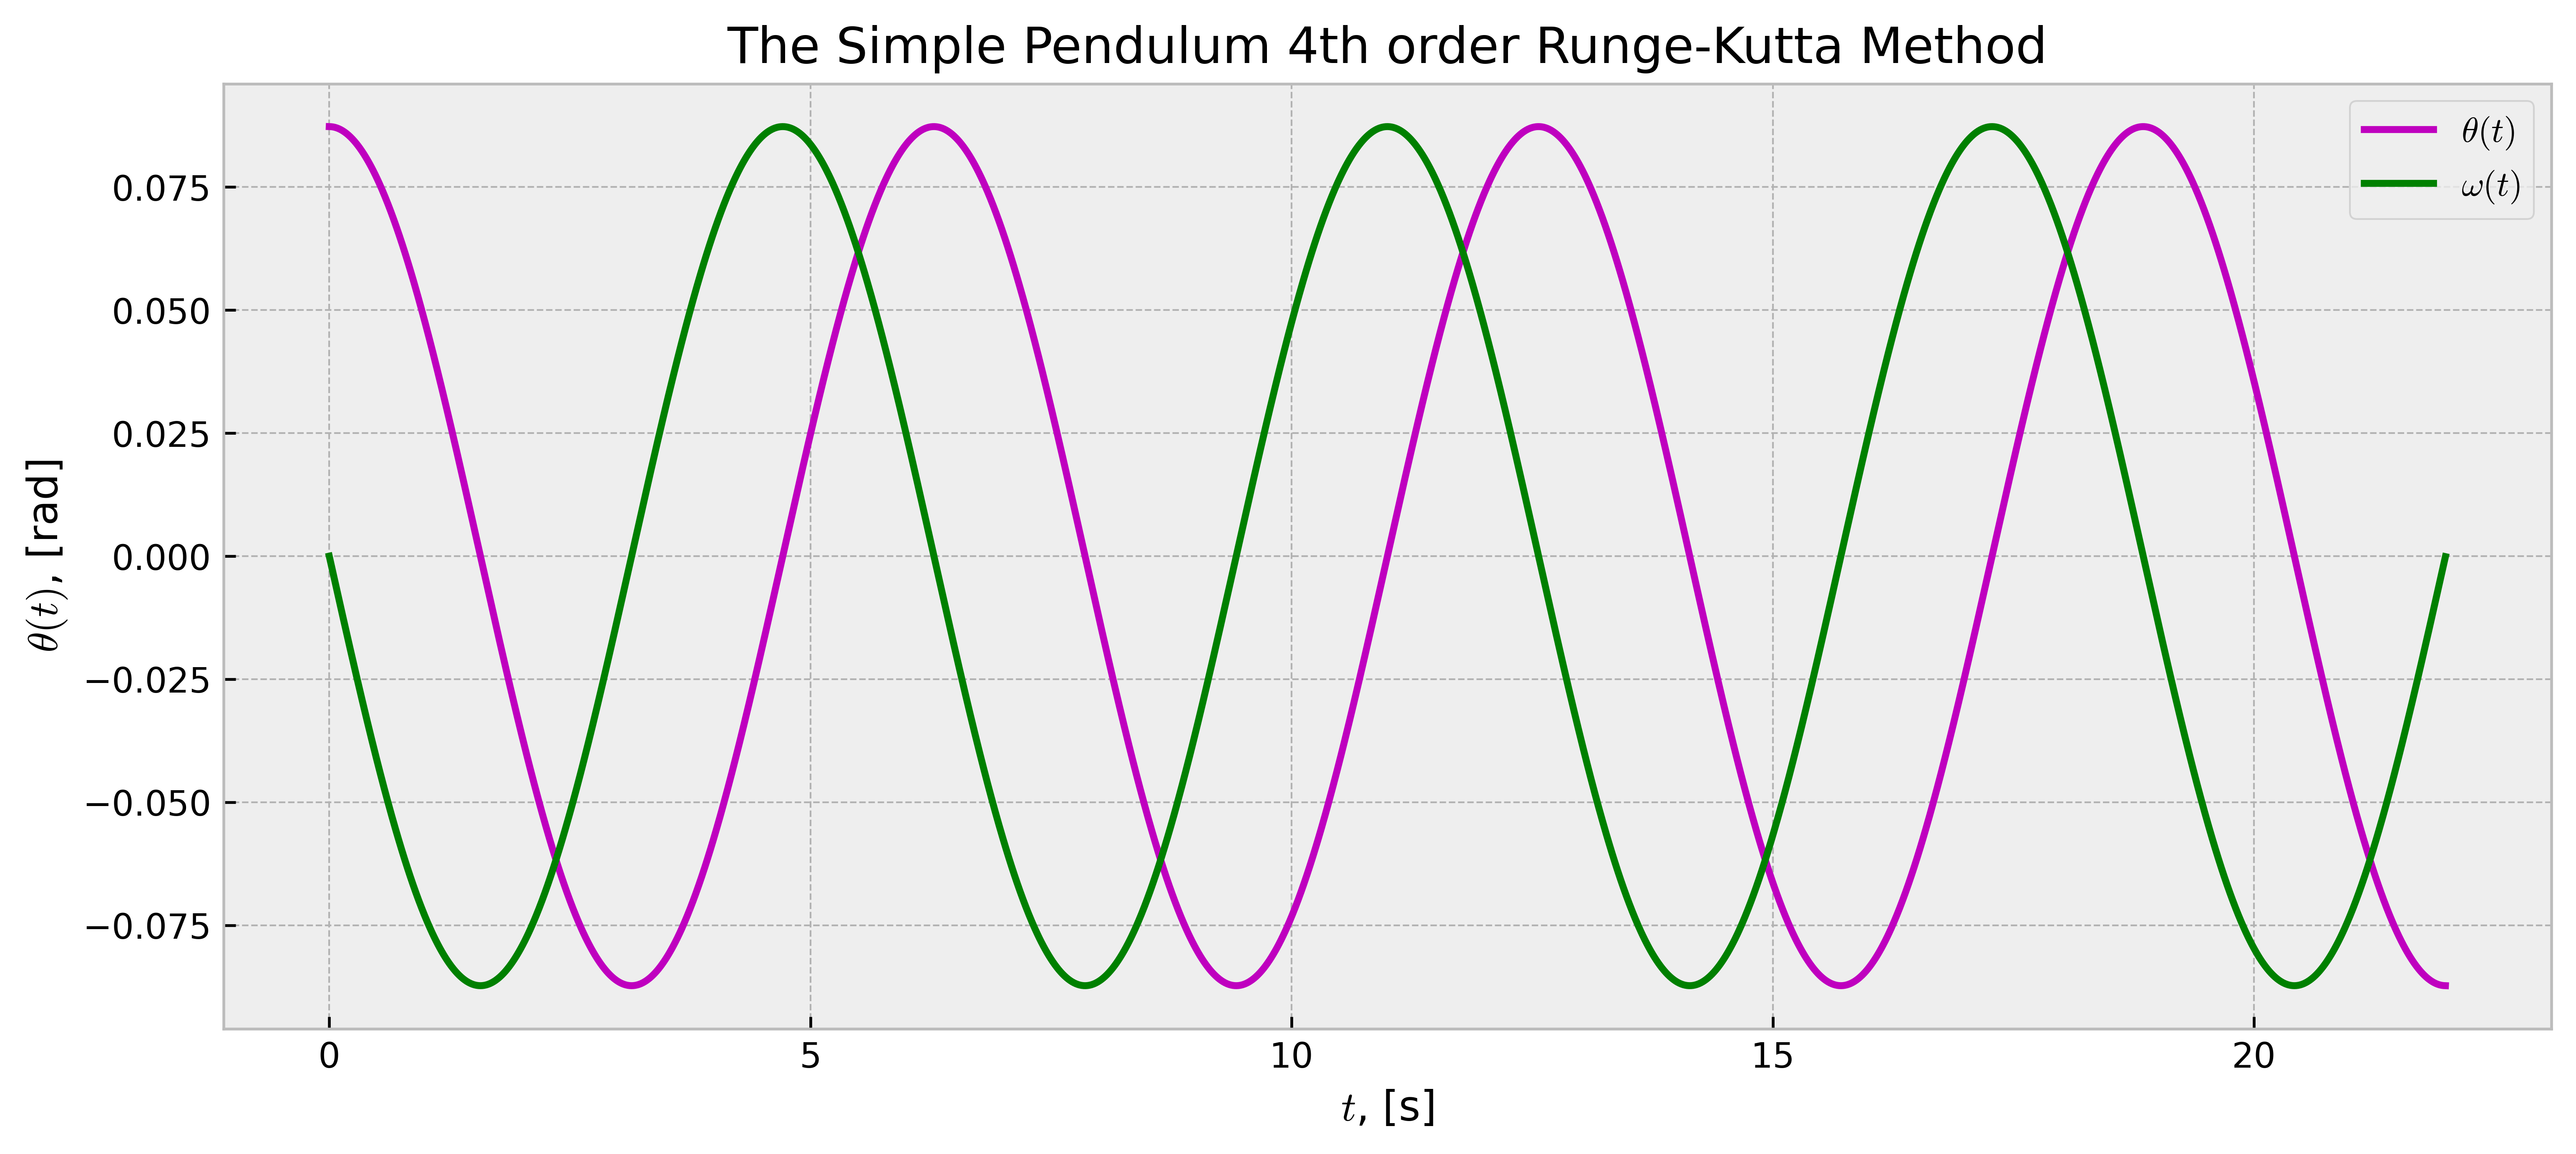

In [6]:
plt.figure(figsize=figsize, dpi=dpi)
plt.title("The Simple Pendulum 4th order Runge-Kutta Method")
plt.plot(T1, A1, "m", label=r"$\theta(t)$")
plt.plot(T1, W1, "g", label=r"$\omega(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

由于理想单摆情况可以给出解析解结果，所以我们可以利用这个特点来检验我们数值模拟的准确性  
我们取振幅为参考量，绘制出对比图像来

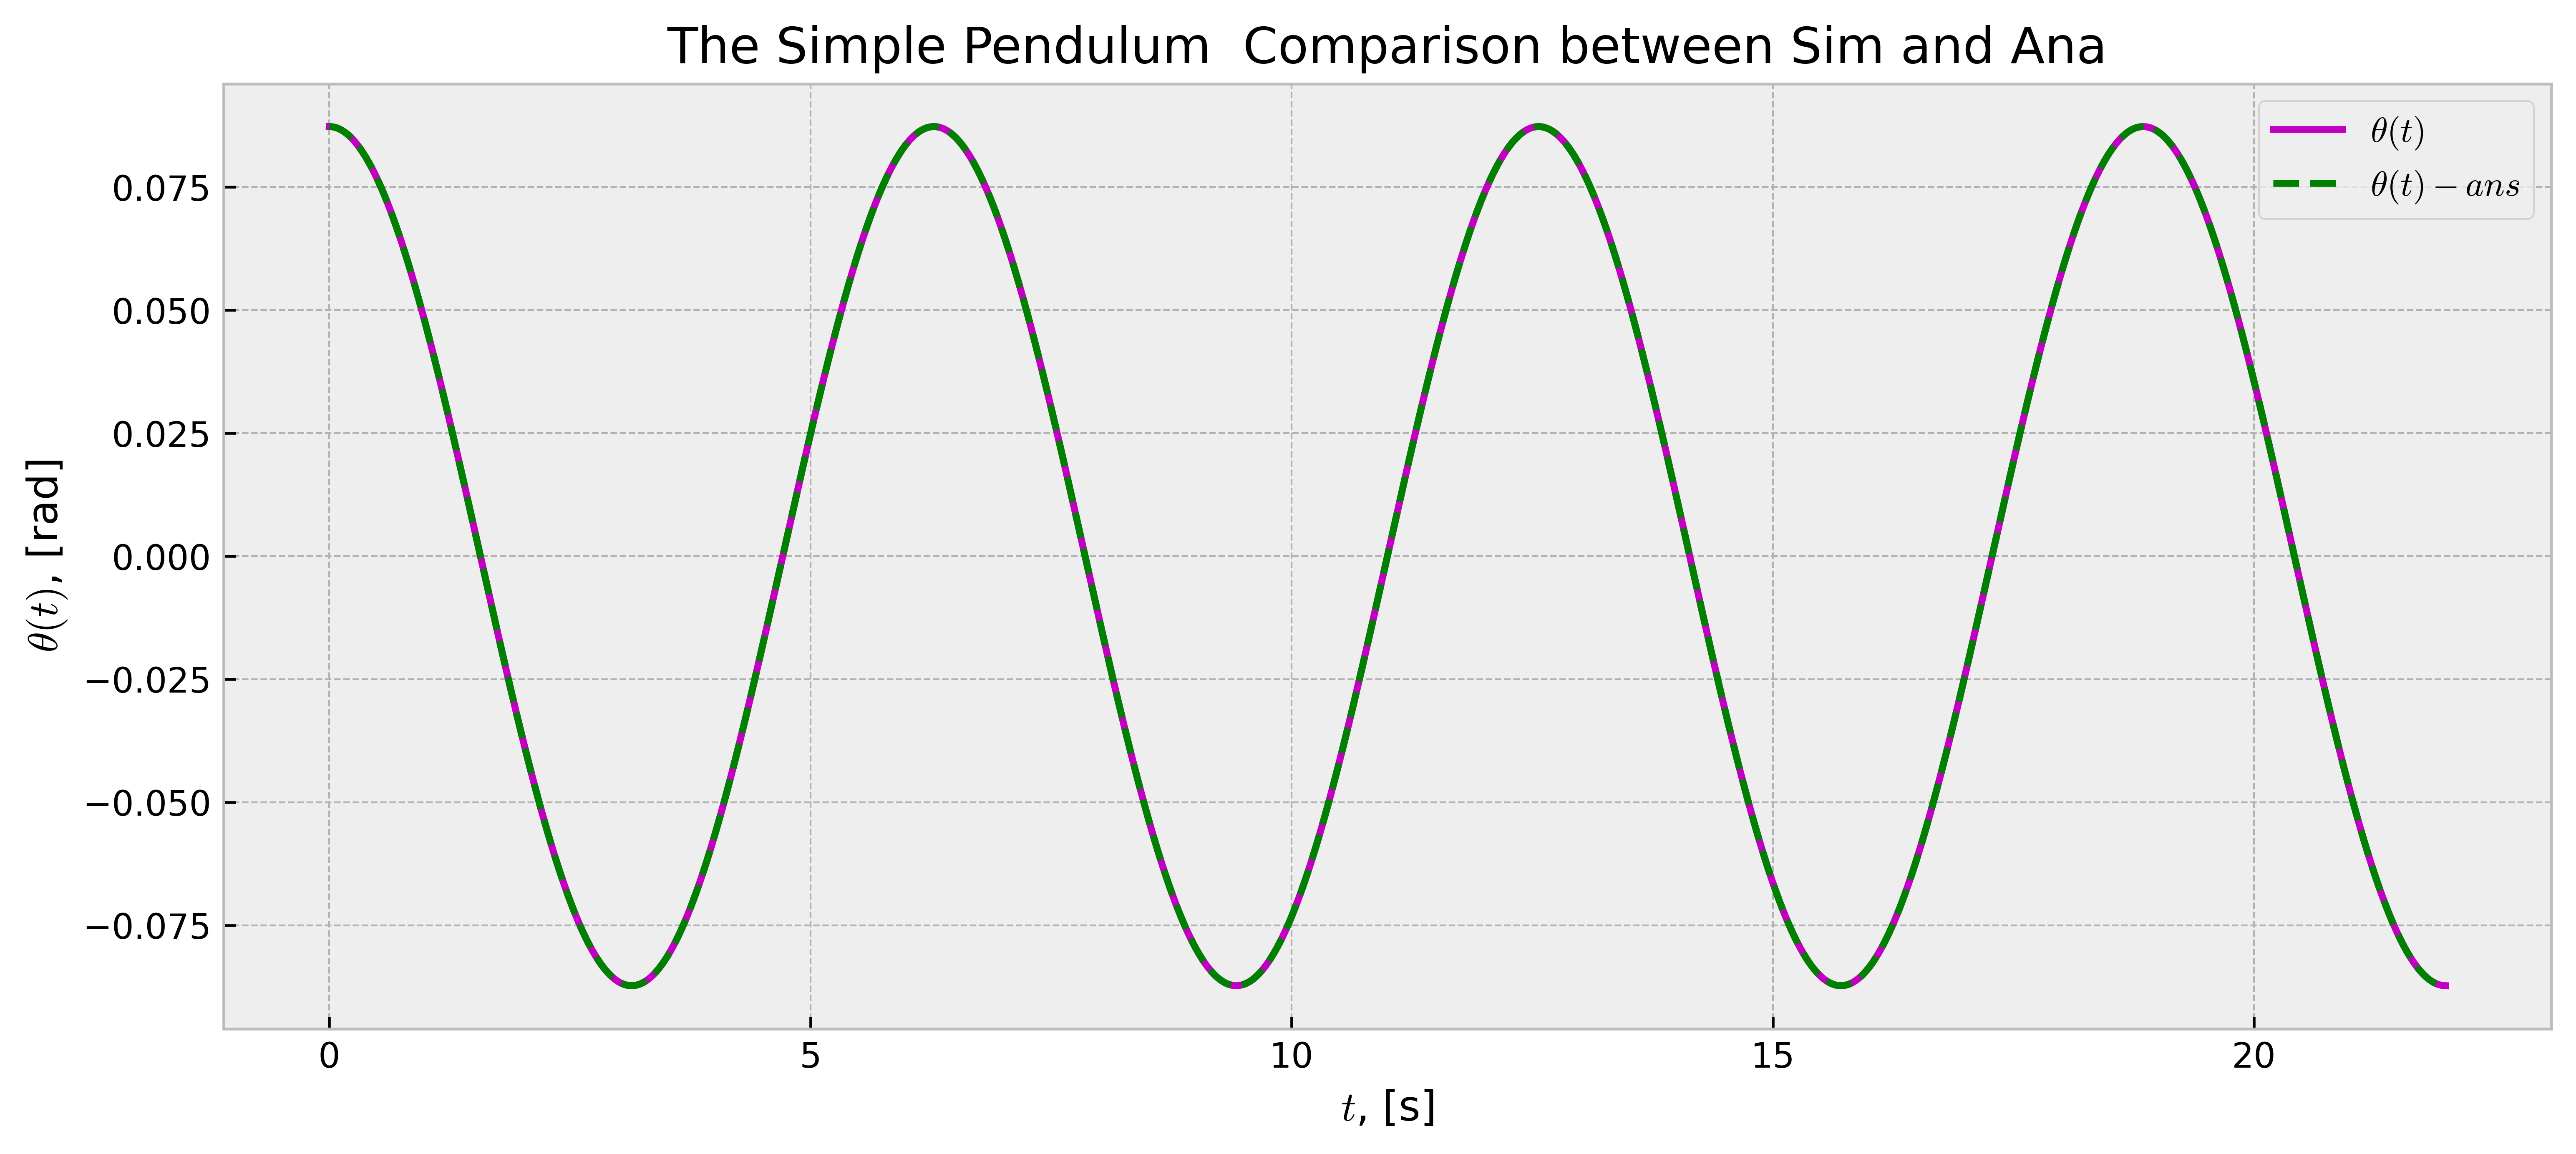

In [7]:
A1_R=a0*np.cos(T1*(g/L)**.5)
plt.figure(figsize=figsize, dpi=dpi)
plt.title("The Simple Pendulum  Comparison between Sim and Ana")
plt.plot(T1, A1, "m", label=r"$\theta(t)$")
plt.plot(T1, A1_R, "g--", label=r"$\theta(t)-ans$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

可以看到，在大致两个周期的范围内，四阶龙格-库塔法的模拟结果简直堪称为完美，拟合得天衣无缝！  
使用如此神兵利器，我们可以直接讨论后续问题!

## Part 2 大角度单摆 Large Angular Pendulum

有了四阶龙格-库塔法解决单摆问题的模型后，最为简单的拓展应用就是修改微分方程的右项  
而最简单的，具有实际意义的修改，就是非小角度近似条件，这对应上文近似条件的第一条  
值得说明的是，这里虽然是大角度单摆，但其摆动角不会大于90°，即不会成为倒立摆

### 2.1 摆条件分析

这是单摆非近似条件中较为方便解决的问题，对方程的影响也就是右边函数的非线性  
在解单摆的方程时，我们由于使用了小角度近似，使得 sinθ 的取值可以近似取为 θ 的取值    
但在大角度单摆的情况下，不满足这个解法，我们可以通过后续的模拟来看出两个不同函数条件下的差距  

**这里相当于在微分方程中，将之前的简单线性函数变为复杂非线性函数**

其中微分方程修正为如下的方程：
<img style="float: middle;" src="2-1.png" width="16%">

### 2.2 初值条件及参数说明

a.原来的参数项：
```python
global L                      #m 单摆的摆长
L = 10
global g                      #m/s^2 重力加速度
g = 10
global fw                     #rad/s 摆动频率
fw = np.sqrt(g/L)


global t                      #单摆运动的时间 s
t = np.arange(0,10,0.01)
global w0                     #单摆运动的初始角速度 rad/s
w0 = 0
global W                      #单摆运动的角速度集合 rad/s
W = [w0]
global a0                     #单摆的摆动初始角度 rad
a0 = (5/180)*np.pi
global A                      #单摆的摆动角度集合 rad
A = [a0]
```

b.需要添加和修改的参数项：

In [8]:
global al                     #修改单摆的初始条件 rad
al = (60/180)*np.pi           #初始值赋予60°，区别与之前的5°

### 2.3 数值解解法

有了上文对单摆模型的数值解解法，直接参考四阶龙格-库塔法（4th order Runge-Kutta Method）解法,稍微修改部分参数条件，可以得到数值解的新方程
由于数值模拟核心算法相似，这里其他地方不过多注释，只是增加部分修改的注释内容

In [9]:
#先定义初始函数，这里dwl就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
#首先，dwl的函数有变化，和dw不同这里需要改变a的算法形式为下
# code by bear

def dwl(a,w,_t):
    return ( -g * np.sin(a) / L )

#定义RK函数,为了区别，这里用RK_2来区别和单摆模拟算法

def RK_2(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        #这里修改了函数，将dw改为dwl
        k11 = _w
        k21 = dwl(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dwl(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dwl(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dwl(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

### 2.4 结果输出

根据上述针对大角度的修改解析模拟，应用上述函数，只需要把函数的参数输入到需要计算的步骤中就好，如下所示：

In [10]:
#其他不改变，初始条件中初始振幅修改为al，dt步长取为0.01，总共取22s的运行周期
Res=RK_2(al,w0,0.01,22)
T2=Res[:,0]
A2=Res[:,1]
W2=Res[:,2]

用同样的方式进行绘图，展示结果：

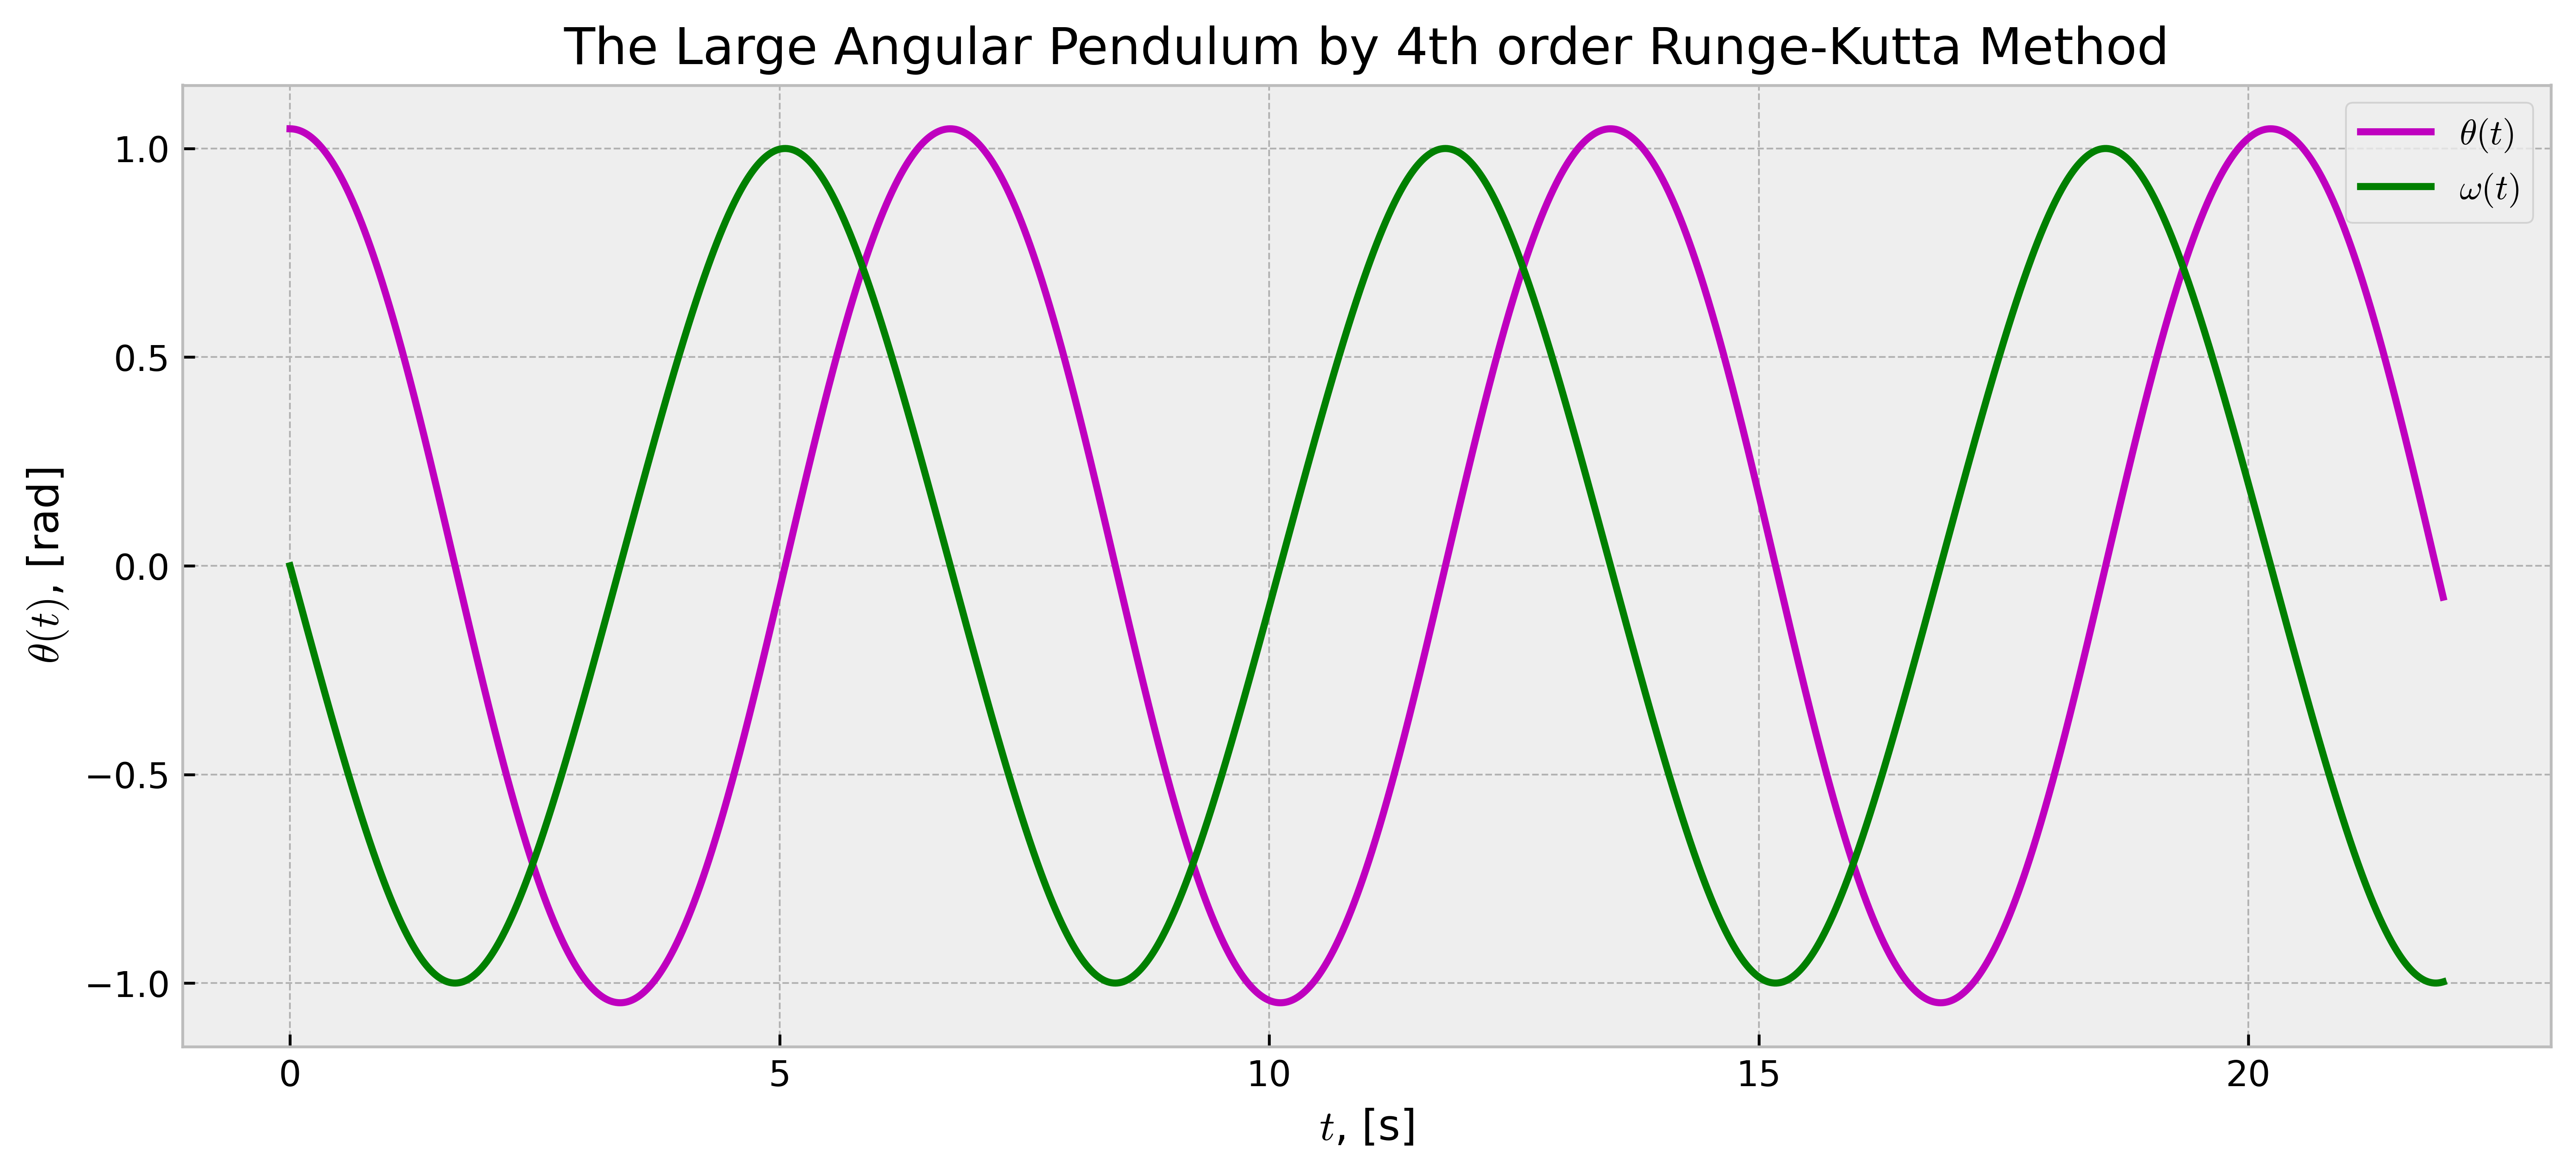

In [11]:
plt.figure(figsize=figsize, dpi=dpi)
plt.title("The Large Angular Pendulum by 4th order Runge-Kutta Method")
plt.plot(T2, A2, "m", label=r"$\theta(t)$")
plt.plot(T2, W2, "g", label=r"$\omega(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

这里好像看不出太多差别，但我们用大角度初始条件对单摆的模拟进行计算的话就会出现差别：

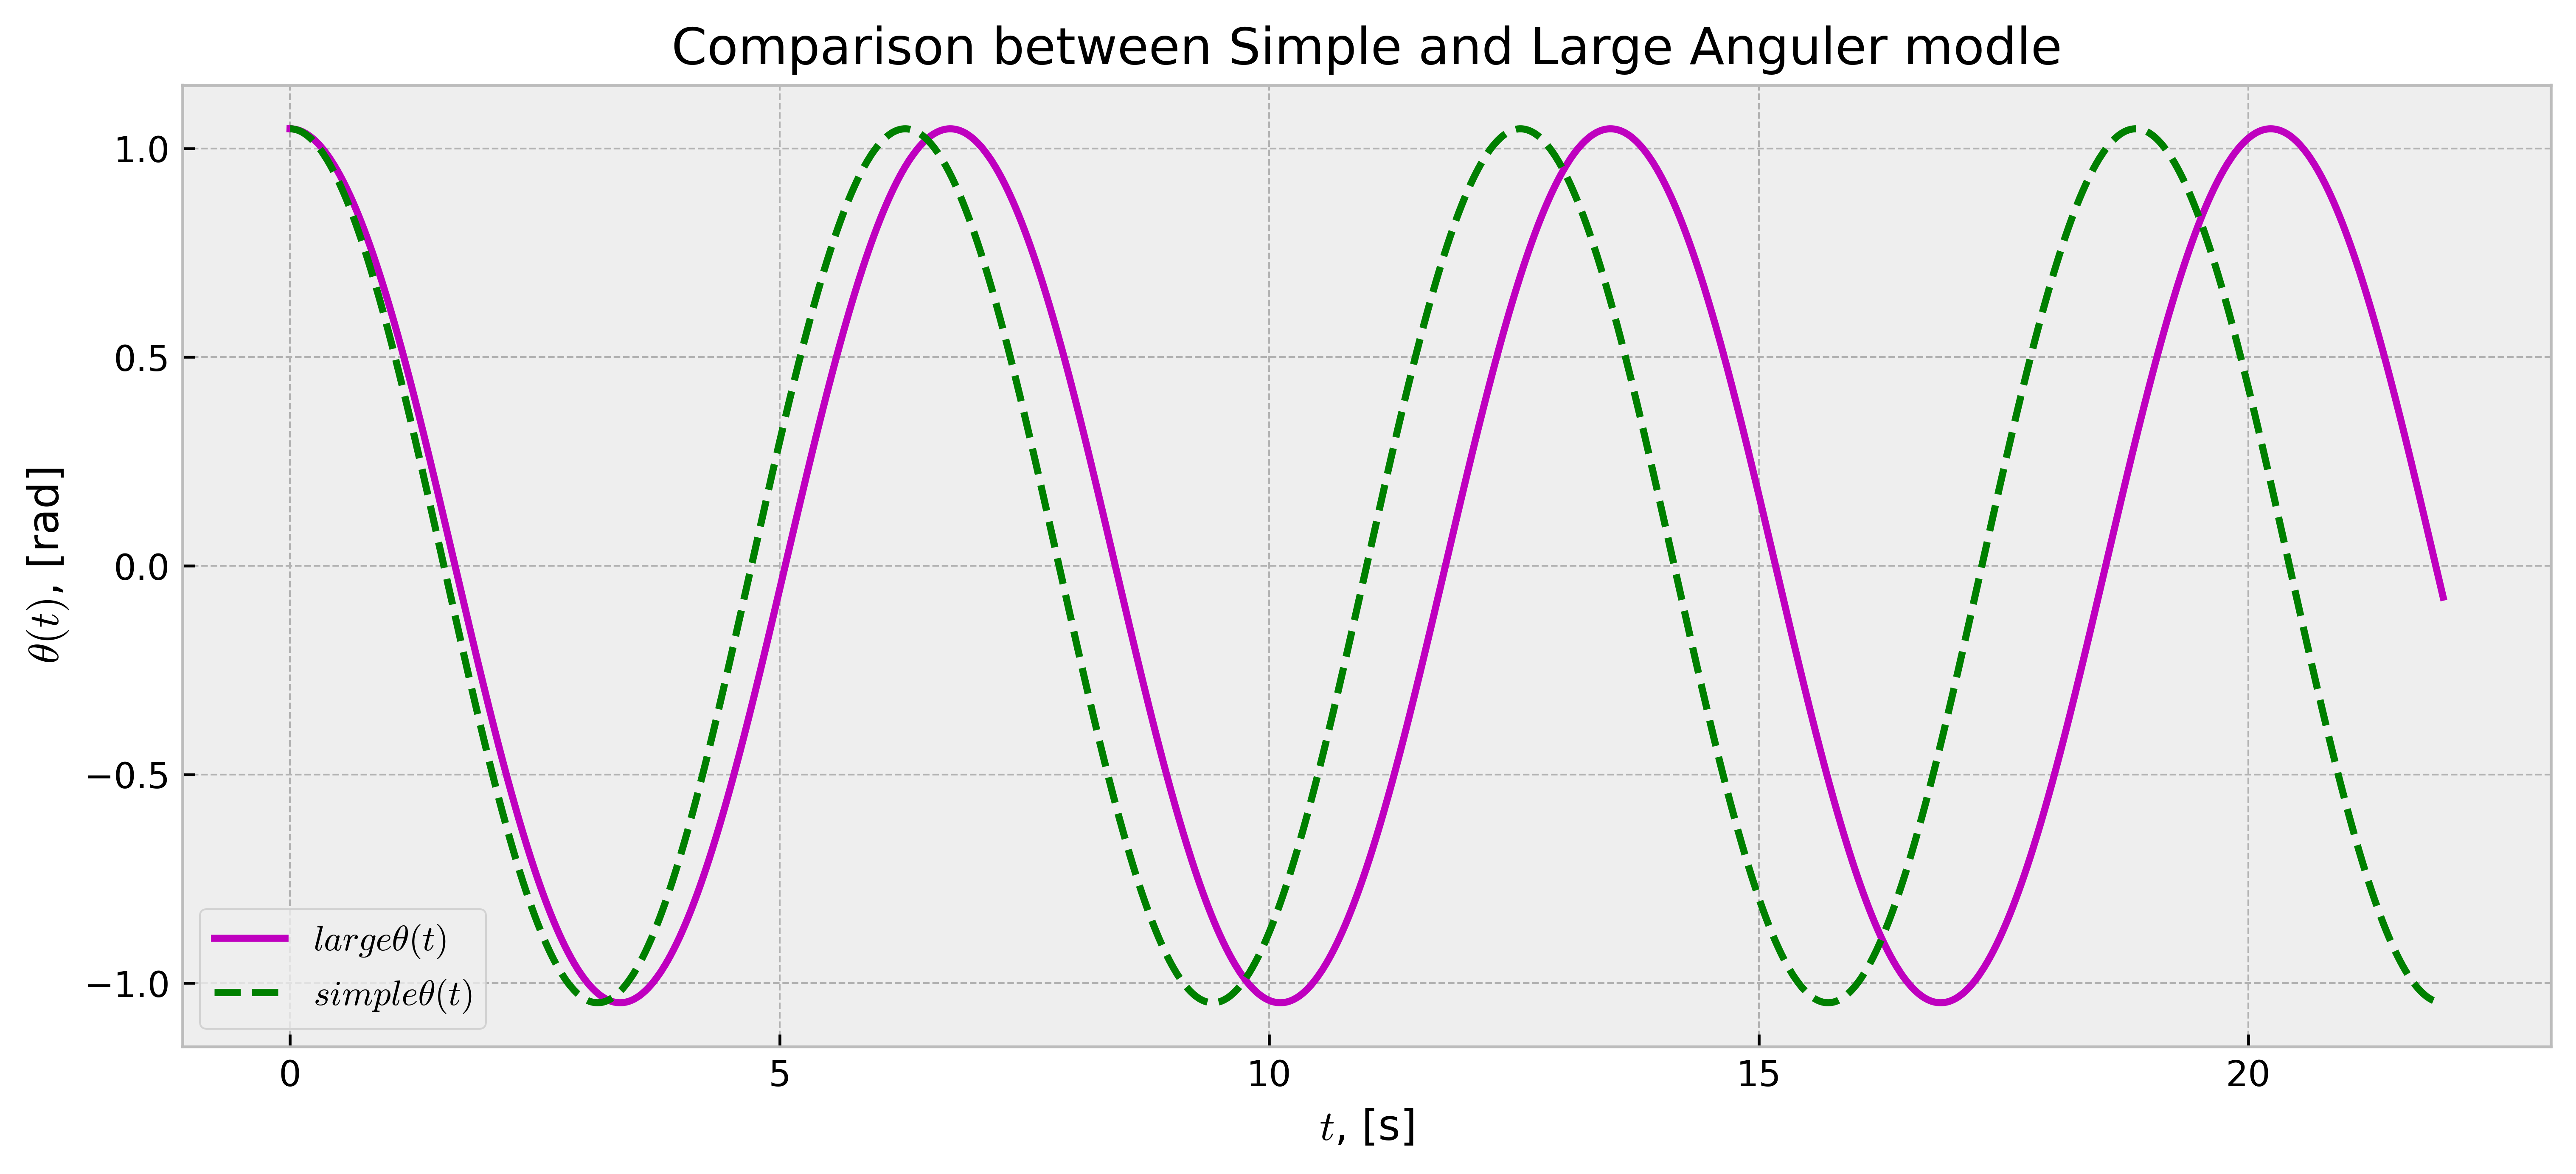

In [12]:
#用大角度边界条件，但使用简单模型的数值解法
Res=RK_1(al,w0,0.01,22)
T2_s=Res[:,0]
A2_s=Res[:,1]
W2_s=Res[:,2]

plt.figure(figsize=figsize, dpi=dpi)
plt.title("Comparison between Simple and Large Anguler modle")
plt.plot(T2, A2, "m", label=r"$large\theta(t)$")
plt.plot(T2_s, A2_s, "g--", label=r"$simple\theta(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

很明显地看到，在角度稍微加大后，这里的函数差异还是非常大的，在两个周期左右，差异以及非常大了

### * *有个很有意思的事情*

如果在这个方程中，将软轻绳改为硬质绳，我们可以将震动角度增大到90°以上，我们先直接看看图像会变成什么样子

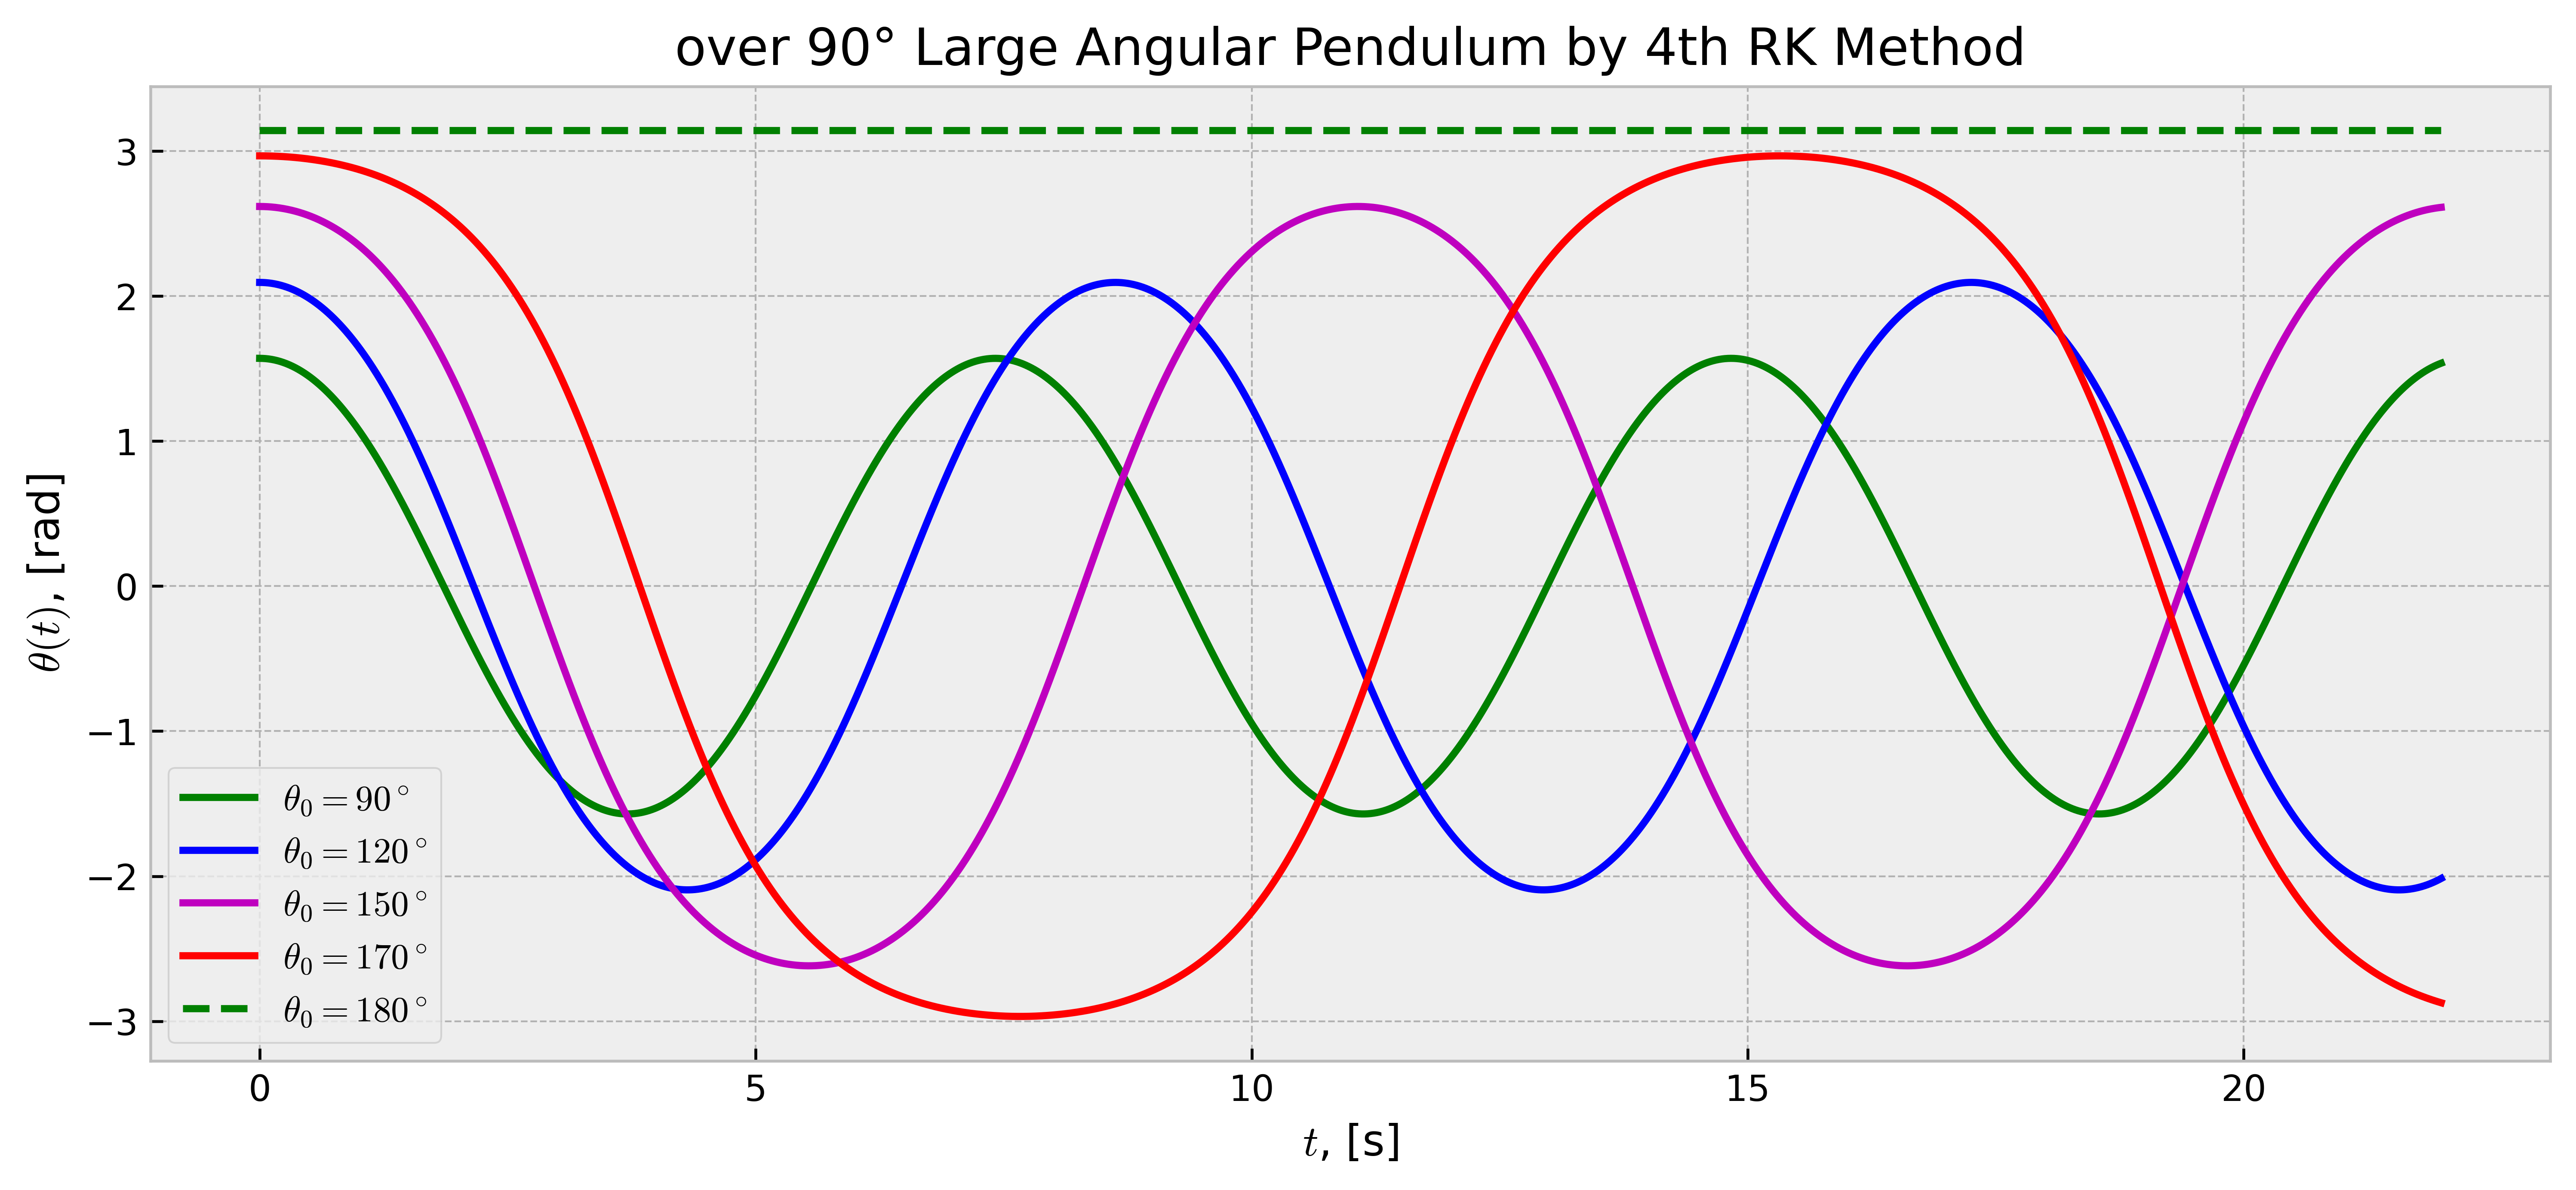

In [13]:
aL1 =  (90/180)*np.pi    #取初始条件中，振幅修改为90°
aL2 = (120/180)*np.pi    #取初始条件中，振幅修改为120°
aL3 = (150/180)*np.pi    #取初始条件中，振幅修改为150°
aL4 = (170/180)*np.pi    #取初始条件中，振幅修改为170°
aL5 = (180/180)*np.pi    #取初始条件中，振幅修改为180°

#计算数据，这不需要什么额外注释
Res=RK_2(aL1,w0,0.01,22)
T2_t1=Res[:,0]
A2_t1=Res[:,1]
W2_t1=Res[:,2]

Res=RK_2(aL2,w0,0.01,22)
T2_t2=Res[:,0]
A2_t2=Res[:,1]
W2_t2=Res[:,2]

Res=RK_2(aL3,w0,0.01,22)
T2_t3=Res[:,0]
A2_t3=Res[:,1]
W2_t3=Res[:,2]

Res=RK_2(aL4,w0,0.01,22)
T2_t4=Res[:,0]
A2_t4=Res[:,1]
W2_t4=Res[:,2]

Res=RK_2(aL5,w0,0.01,22)
T2_t5=Res[:,0]
A2_t5=Res[:,1]
W2_t5=Res[:,2]

#作图结果
plt.figure(figsize=figsize, dpi=dpi)
plt.title("over 90° Large Angular Pendulum by 4th RK Method")
plt.plot(T2_t1, A2_t1, "g", label=r"$\theta_0= 90^\circ$")
plt.plot(T2_t2, A2_t2, "b", label=r"$\theta_0=120^\circ$")
plt.plot(T2_t3, A2_t3, "m", label=r"$\theta_0=150^\circ$")
plt.plot(T2_t4, A2_t4, "r", label=r"$\theta_0=170^\circ$")
plt.plot(T2_t5, A2_t5, "g--", label=r"$\theta_0=180^\circ$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

从这个结果可以发现，当角度从90°逐渐增加，整个振动还是呈现周期性，但是：
1. 随着角度增大，和简谐运动差异越来越大
2. 振动的特征和变化特点，如振幅和周期，和低角度单摆在定性层面相符合，但定量上面不可相似

## Part3 阻尼单摆 Friction Pendulum (Damped Pendulum)

除了在Part2的大角度单摆，单摆中最容易被打破的就是阻尼问题  
在牛顿第二定律的基础上，我们先假设最简单的情况，就是简单认为阻尼是速度的线性函数，以此可以给出下面的运动学微分方程：
<img style="float: middle;" src="3-1.png" width="22%">
虽然在描述中，我们说的是“假定阻尼是速度的线性函数”，实际上阻尼也确实满足这个关系，最典型的阻尼就是空气阻力，而它大小就是和速度满足线性关系

### 3.1 摆条件分析

上述以及说明过考虑阻尼后，微分方程多了一个一阶项  
我们先不急着将多个问题组合到一起，这里我们先假定单摆的小角度，也就是将 sinθ 近似为 θ然后接着处理后续问题  
这很显然我们需要引入一个新的参数，阻尼系数b  
同时，这也是一个二阶方程，如果我们要用四阶龙格-库塔法，我们就需要将上述方程分解为两个一次方程，方程如下：  
<img style="float: middle;" src="3-2.png" width="18%">

**这里相当于微分方程中引入了一个关于角速度的函数，对与复杂函数寻找解析解会很复杂，但在数值解中会很容易，关于这点，会在最后一节详细讨论**

### 3.2 初值条件及参数说明

a.原来的参数项：
```python
global L                      #m 单摆的摆长
L = 10
global g                      #m/s^2 重力加速度
g = 10
global fw                     #rad/s 摆动频率
fw = np.sqrt(g/L)


global t                      #单摆运动的时间 s
t = np.arange(0,10,0.01)
global w0                     #单摆运动的初始角速度 rad/s
w0 = 0
global W                      #单摆运动的角速度集合 rad/s
W = [w0]
global a0                     #单摆的摆动初始角度 rad
a0 = (5/180)*np.pi
global A                      #单摆的摆动角度集合 rad
A = [a0]
```

b.需要添加和修改的参数项：

In [14]:
global u
# u就是微分方程中的阻尼常数项，严格来讲这个项应该和质量大小有关系，但因为质量也是常数，我们可以直接把这些常数合并在一起
u = 1

### 3.3 数值解解法

根据3.1提供的方程，相较于最开始的数值解法，在四阶龙格-库塔法（4th order Runge Kutta Method）函数的基础上，进行简单修改即可，我只会在必要部分进行注释，因为代码思路几乎一致

In [15]:
#先定义初始函数，这里dwl就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
#由于阻尼的影响，方程右边增加了角速度的相关项，所以需要进行修改，这里把函数改成dwf
# code by bear

def dwf(a,w,_t):
    return ( -g * a / L - u * w / L)

#定义RK函数,为了区别，这里用RK_3来区别和单摆模拟算法

def RK_3(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        #这里修改了函数，将dw改为dwf
        k11 = _w
        k21 = dwf(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dwf(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dwf(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dwf(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

### 3.4 结果输出

计算步骤和上述相似，我以及在必要的地方进行了批注：

In [16]:
#其他不改变，改变运行的模拟算法匹配阻尼摆的模型，dt步长取为0.01，总共取22s的运行周期
Res=RK_3(a0,w0,0.01,22)
T3=Res[:,0]
A3=Res[:,1]
W3=Res[:,2]

数据运行出结果了，可以直接绘制图表

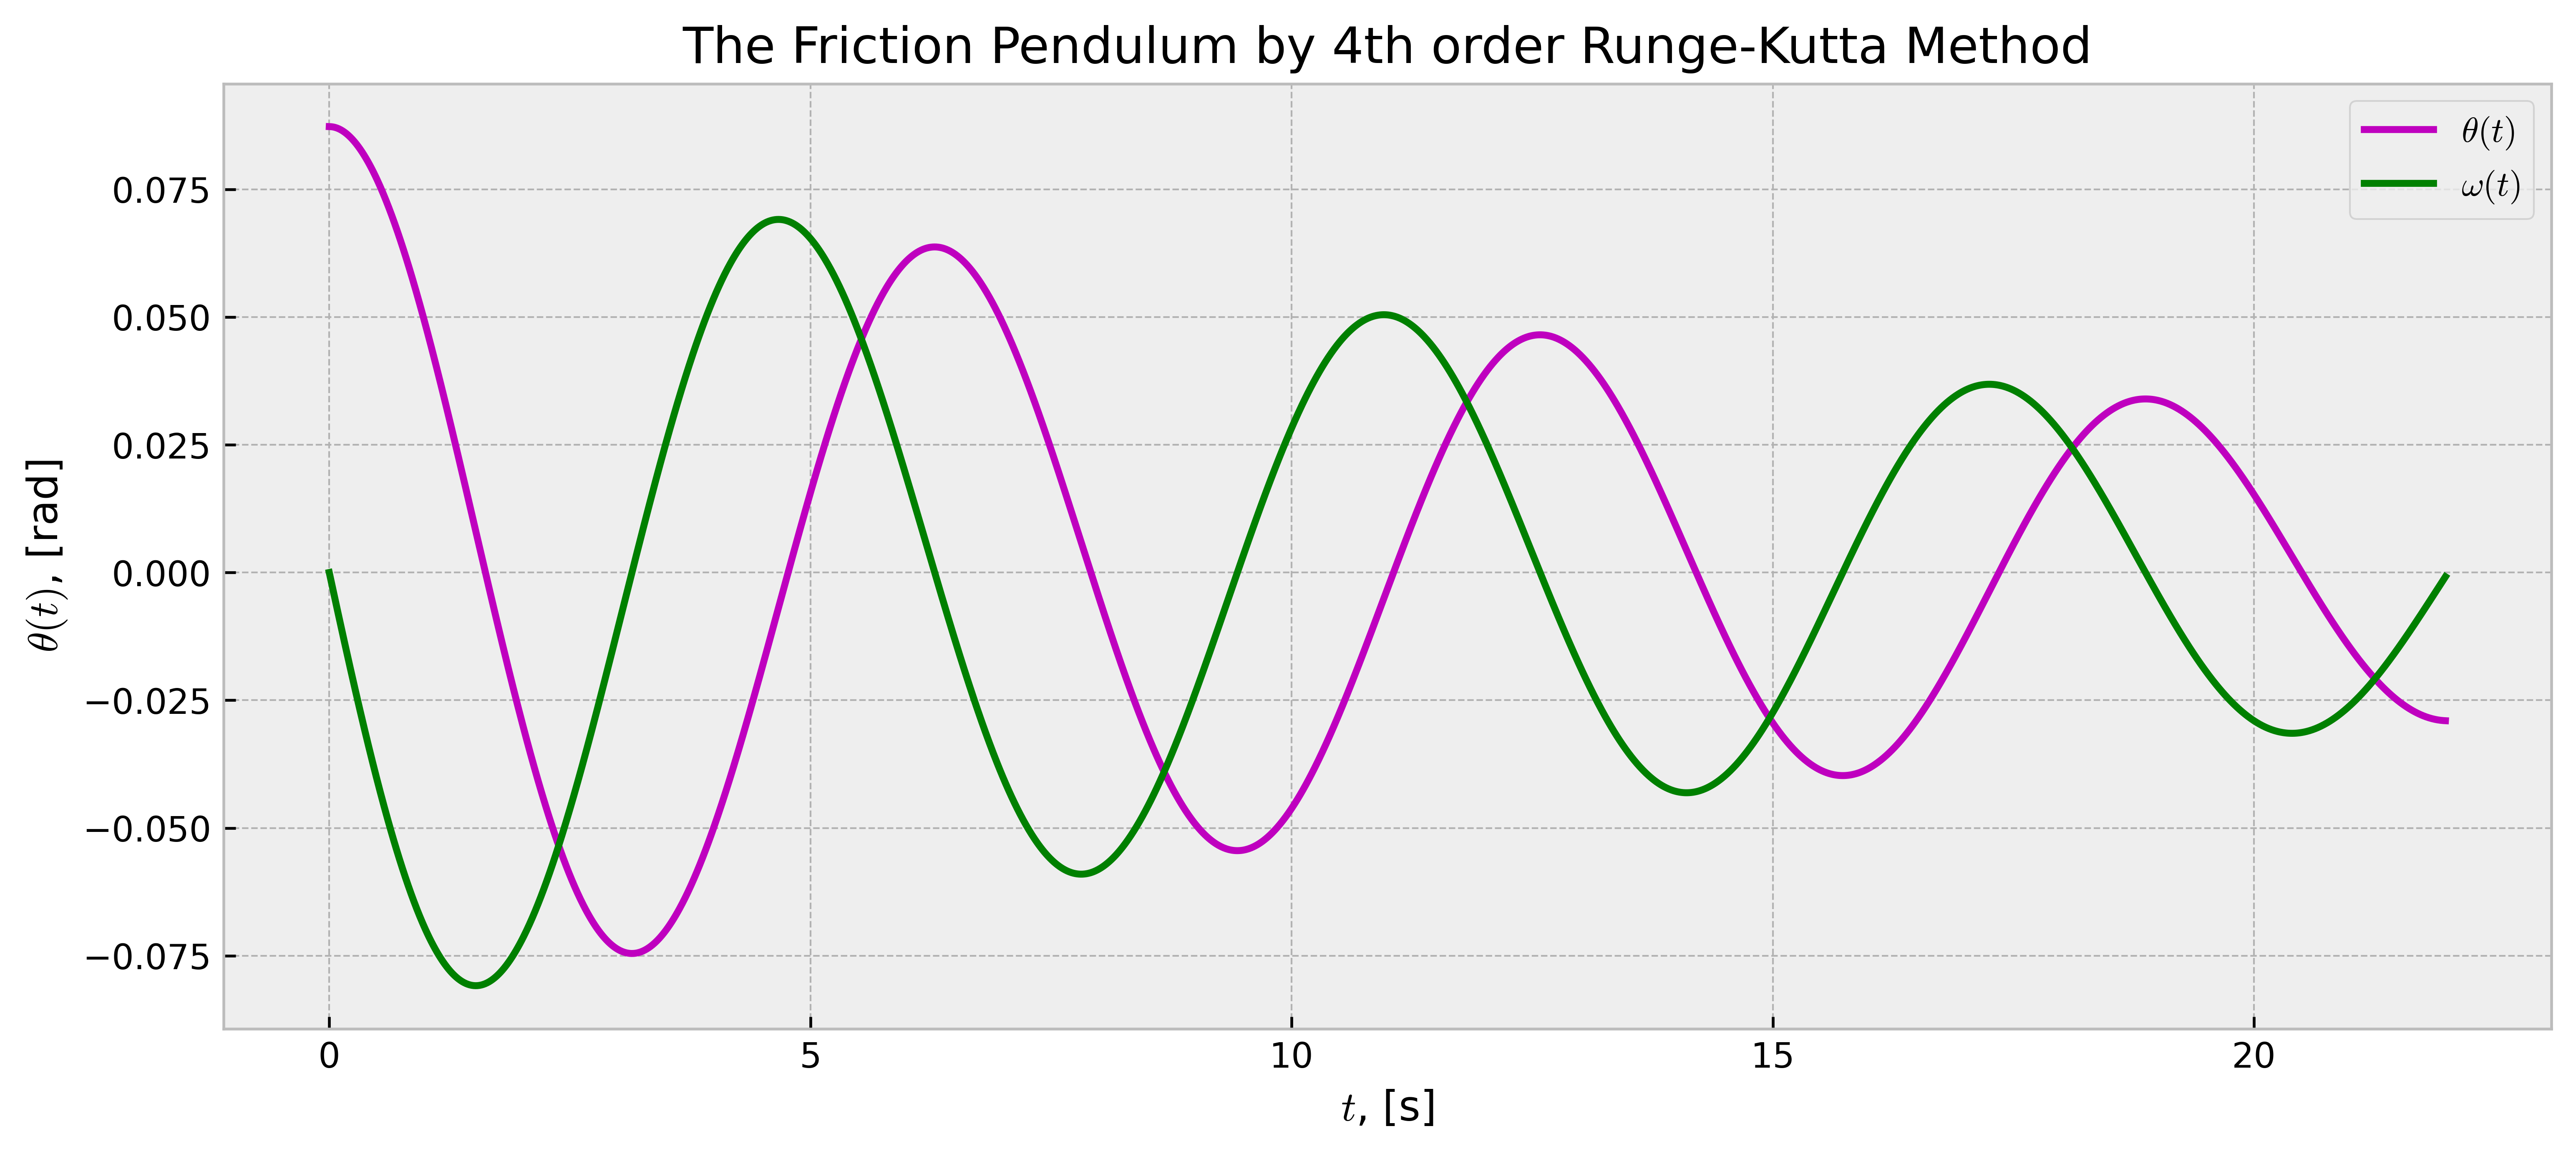

In [17]:
plt.figure(figsize=figsize, dpi=dpi)
plt.title("The Friction Pendulum by 4th order Runge-Kutta Method")
plt.plot(T3, A3, "m", label=r"$\theta(t)$")
plt.plot(T3, W3, "g", label=r"$\omega(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

可以看到，这个阻尼的减少效果还是很明显的，如果我们延长一点运行时间，大概100s左右，这个摆就会基本上停止震动，图像如下：

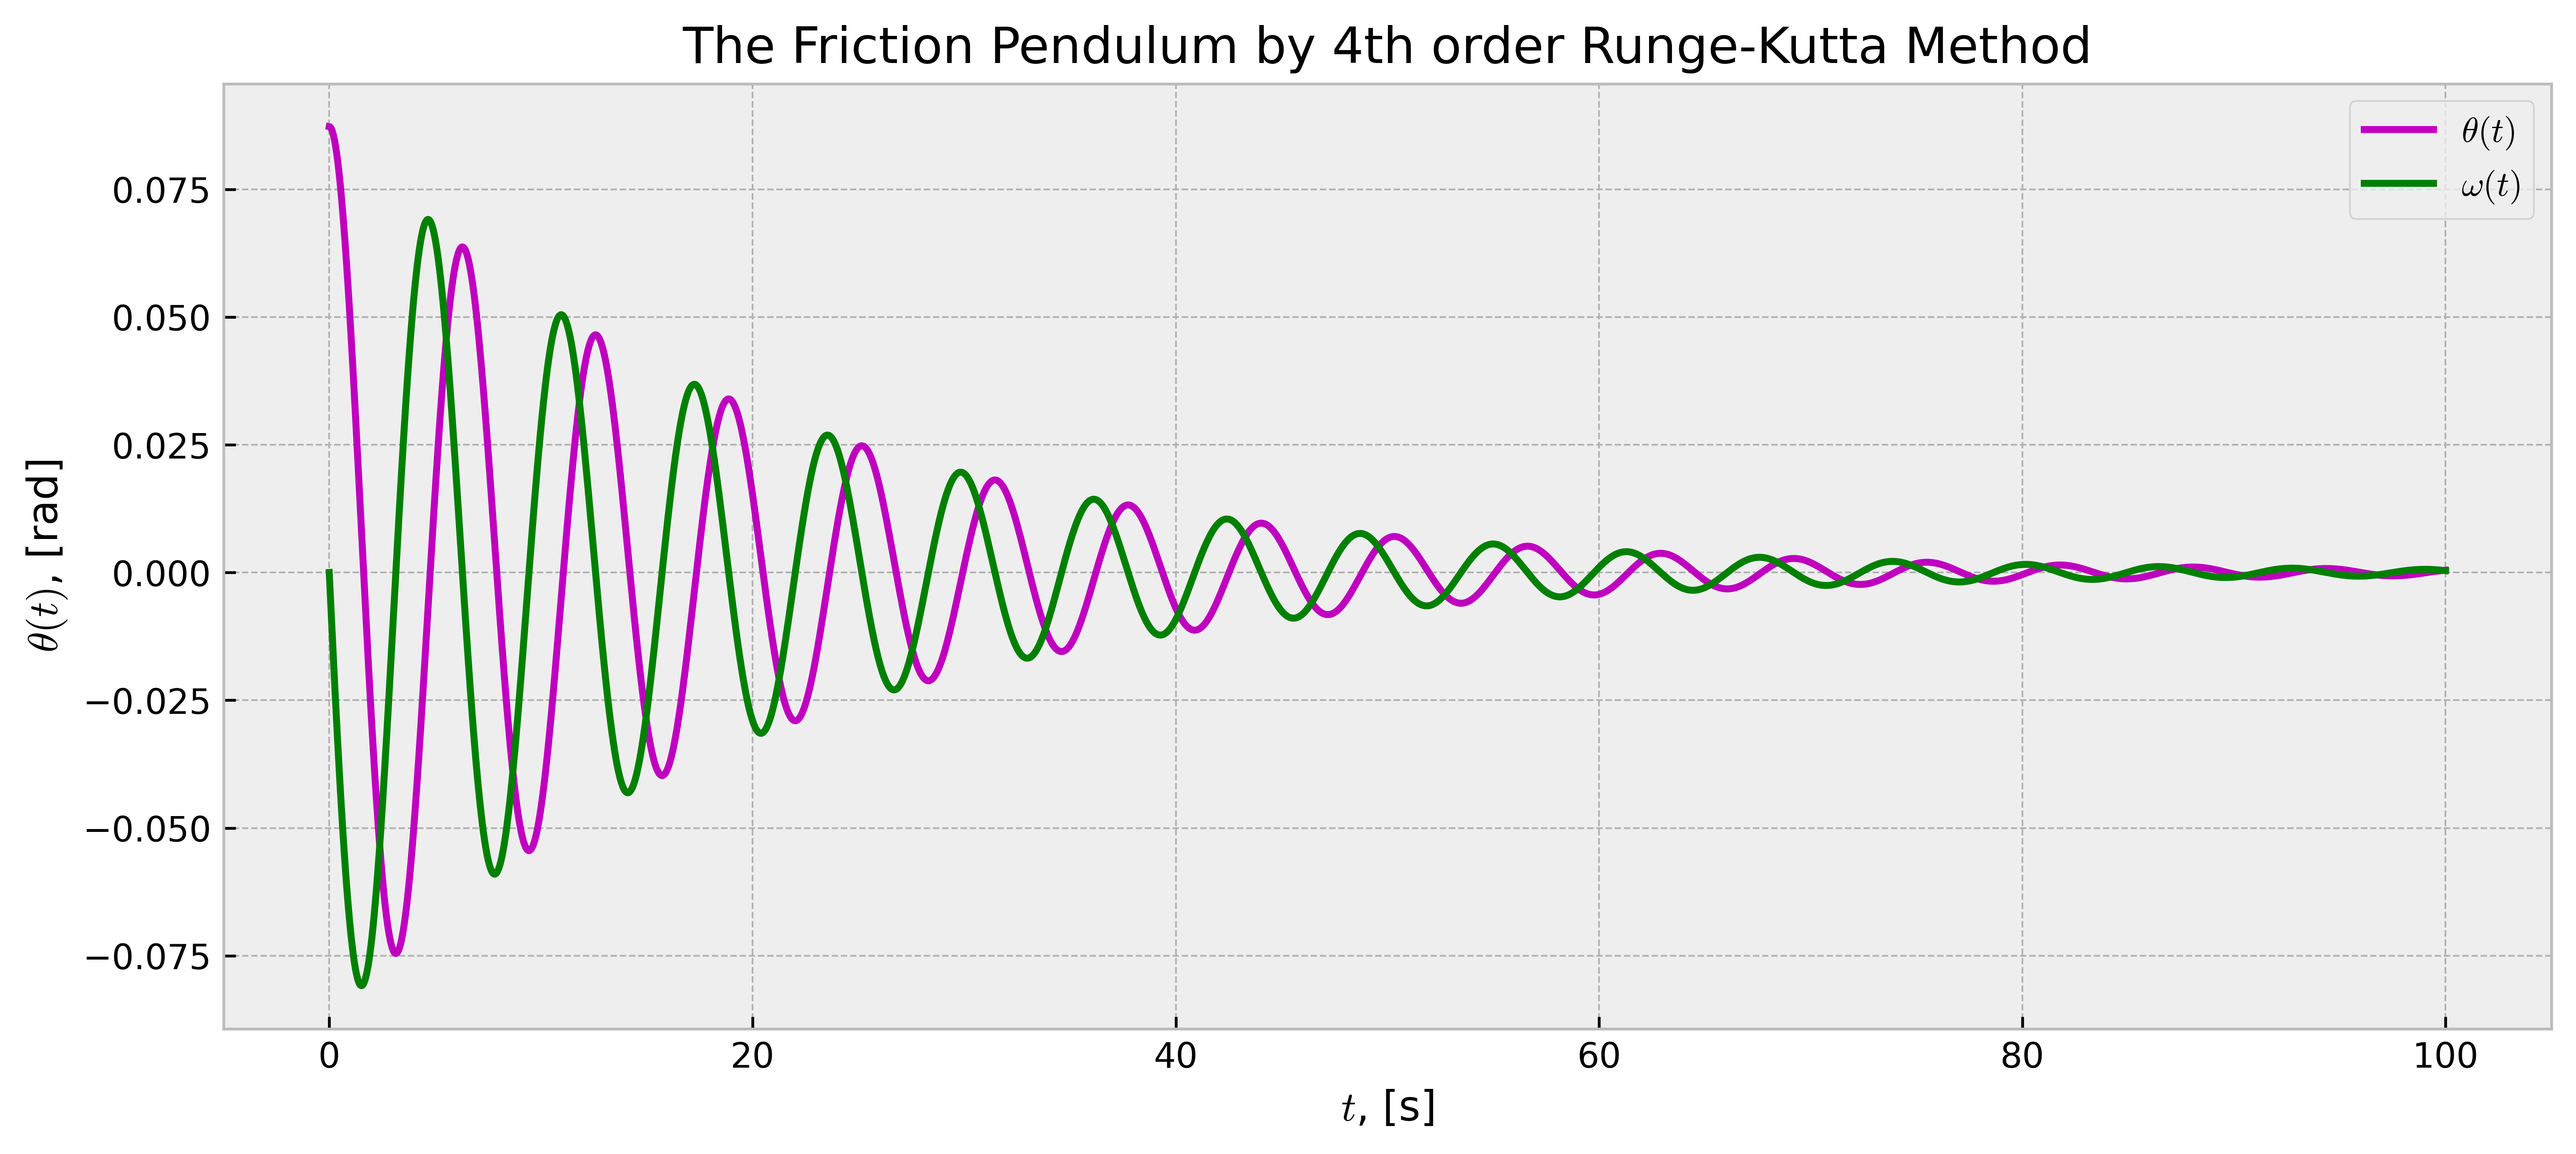

In [18]:
Res=RK_3(a0,w0,0.01,100)
_T3=Res[:,0]
_A3=Res[:,1]
_W3=Res[:,2]

plt.figure(figsize=figsize, dpi=dpi)
plt.title("The Friction Pendulum by 4th order Runge-Kutta Method")
plt.plot(_T3, _A3, "m", label=r"$\theta(t)$")
plt.plot(_T3, _W3, "g", label=r"$\omega(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

这里必须提一下数值解法的优势，我们可以改变阻尼的参数来观察阻尼大小对振动的影响  
同时，我们不难注意，我们完全可以把阻尼更正为一个负阻尼的负值，这就像是对振动的一个正反馈  
我们将这几个情况都在下面的程序中再现，代码部分完全类似可以直接过度到图像的部分  

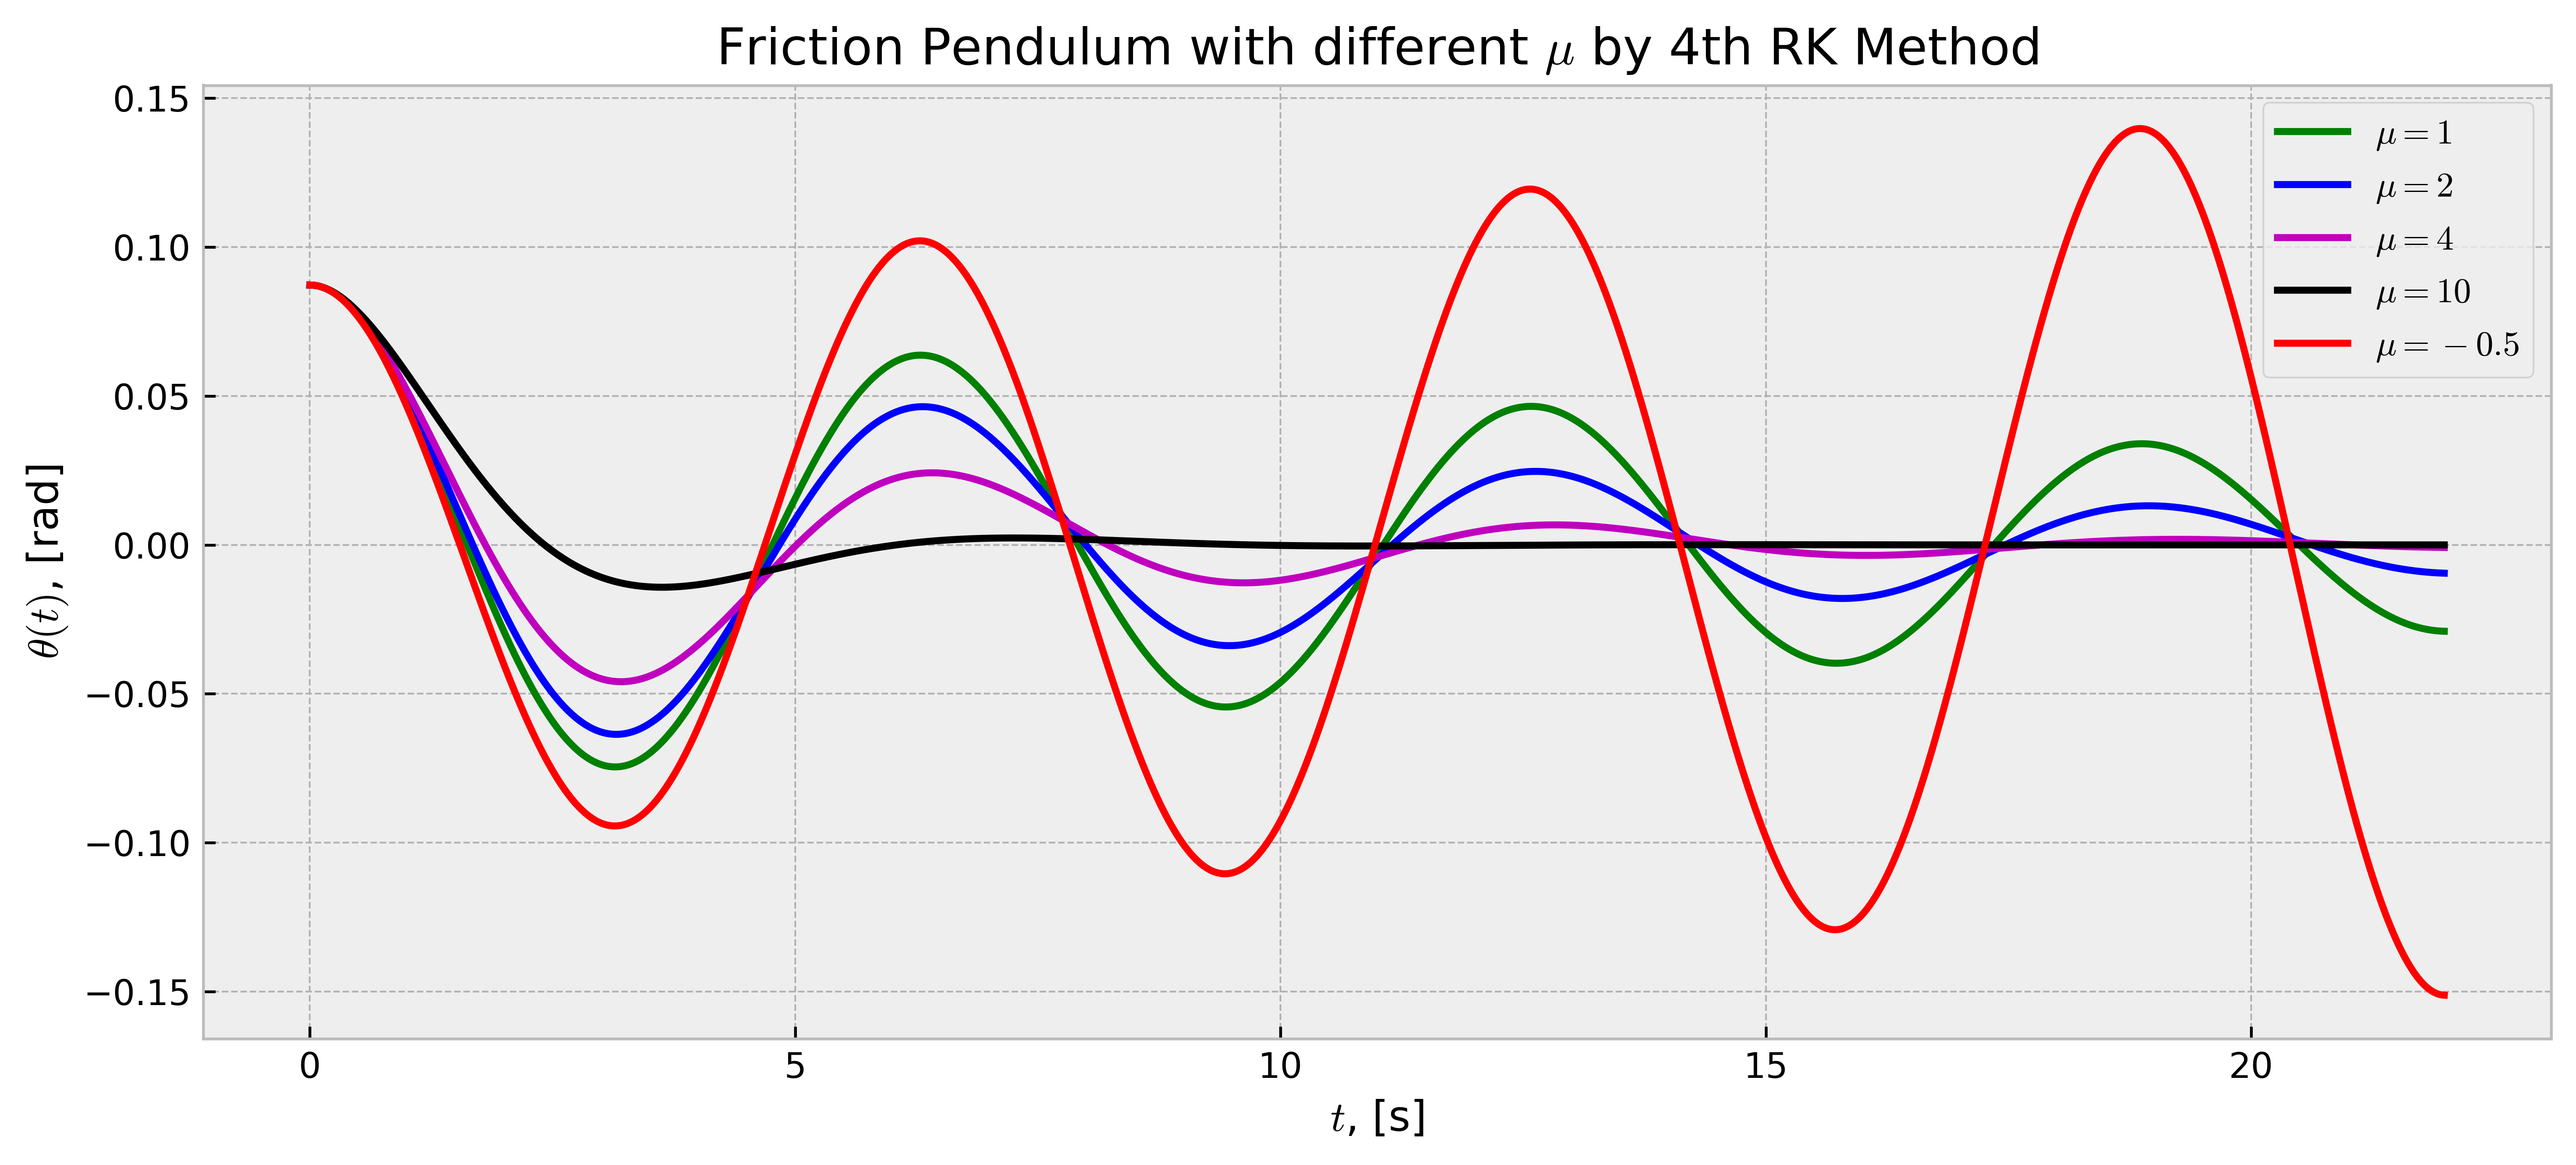

In [19]:
#对每一组阻尼常数，计算一次振动模型：这里分别取阻尼常数为u=1，2，4，10，-2

u=1
Res=RK_3(a0,w0,0.01,22)
T3_1=Res[:,0]
A3_1=Res[:,1]
W3_1=Res[:,2]

u=2
Res=RK_3(a0,w0,0.01,22)
T3_2=Res[:,0]
A3_2=Res[:,1]
W3_2=Res[:,2]

u=4
Res=RK_3(a0,w0,0.01,22)
T3_3=Res[:,0]
A3_3=Res[:,1]
W3_3=Res[:,2]

u=10
Res=RK_3(a0,w0,0.01,22)
T3_4=Res[:,0]
A3_4=Res[:,1]
W3_4=Res[:,2]

u=-0.5
Res=RK_3(a0,w0,0.01,22)
T3_5=Res[:,0]
A3_5=Res[:,1]
W3_5=Res[:,2]

#作图结果
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Friction Pendulum with different $\mu$ by 4th RK Method")
plt.plot(T3_1, A3_1, "g", label=r"$\mu= 1$")
plt.plot(T3_2, A3_2, "b", label=r"$\mu= 2$")
plt.plot(T3_3, A3_3, "m", label=r"$\mu= 4$")
plt.plot(T3_4, A3_4, "k", label=r"$\mu= 10$")
plt.plot(T3_5, A3_5, "r", label=r"$\mu= -0.5$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

从图像上看就非常直观，阻尼摆的衰减程度和阻尼系数u直接相关：
1. 阻尼系数越大，阻尼摆衰减越快；
2. 当阻尼系数足够大，整个系统基本不会摆动（u=10的图像）
3. 阻尼系数为负值时，整个振动会变成正向激励振动（u=-0.5的图像）

## Part4 组合讨论 Complex Pendulum

### 4.1 前述的归纳 

#### 总体的评论和理论价值

前面三个Part分别介绍了，理想单摆、大角度单摆、和阻尼单摆这三个问题  
我必须要指出这里面的逻辑问题：  
Part1 部分的理想单摆，我们给出了理想单摆的理论模型，并提出了一个非常完美的方法论，利用四阶龙格-库塔法（4th order Runge-Kutta Method），可以相当理想地重现振动的问题；  
Part2 部分的大角度单摆，是将理想单摆的微分方程的一些条件进行修改，计算完成后发现，处理微分方程中有复杂参数的问题，我们同样可以使用龙格-库塔法，只是需要将步长函数稍作修改就行，这样可以回避繁琐的数学数值计算；  
Part3 部分的阻尼单摆，这是将微分方程增减项的变化，其实从结果上看来，不论微分方程怎么增减项，不论怎么改变值，我们都能找到龙格-库塔法的通解思路，将二阶微分方程分解为两个一阶微分方程，然后用两次四阶龙格库塔法就能解出结果，所以不论微分方程如何复杂，我们都能有方法处理摆动问题！
  
**所以，通过以上的描述，我们可以说，我们利用数值解法解决了所有的一维振动问题  
注意，这里的振动是广义振动，包括机械振动、电磁振动等，只要能写出某一物理量的振动二阶微分方程，我们就能利用该通解方法将结果解出来！**

#### 方法本身的评论

利用四阶龙格-库塔法解振动问题有如下优点：
1. 解法非常精确，完全不需要给出详细的解析解结果，就能完全模拟整个过程；
2. 避免由于微分方程本身的复杂性而带来的计算困难；
3. 结果非常直观，而且算法适用范围非常广泛；

但其中也有些内容需要完善：
1. 该方法只适用于一维的简谐运动，要想处理多维度的振动问题，如复摆、弹性摆等问题，还需要引入额外的自由度，但理论上来说只是一次重复的工作而已；
2. 这次没有讨论算法的效率问题，相较于通常使用的欧拉法等，该方法显得可能有点消耗算力，这可以根据结果精度需要进行调整；

### 4.2 方法论归纳

***根据前述的总结，我们可以归纳出一套解决所有一维振动的摆动问题的通用方法论：***

### 4.2.1 第一个步骤：确定运动的微分方程

对于复杂问题的微分方程一般不是那么简单地可以得到，通常包含多个维度和多个过程，但总是能通过坐标系分解找到独立的一维振动模型，然后根据这些独立的振动模型组合成复杂的振动运动，根据前述的内容，我们这里详细讨论下一维振动的通用解法：

对一维振动，不论在物理学上有多少作用量，作用量的函数形式有多么复杂，总是能化为一个二阶常微分方程，它们具有通用的形式：
<img style="float: middle;" src="4-1.png" width="22%">

这里 A 是抽象的振动物理学量，dA/dt就是振动的速度  
在单摆问题里 A 就是角度 θ，dA/dt就是角速度w， 或者也可以把它理解成拉格朗日力学中的广义坐标 q，和相应的广义速度dq/dt  
需要说明的是微分方程中每一项的系数都可以是坐标，速度和时间的函数，但最后会留下一个常数  
上述方程看着非常不和谐，我们可以把它整理一下，变成我们喜欢看见的形式：

<img style="float: middle;" src="4-2.png" width="42%">

其中B就是广义速度，A就是广义坐标，L对应其系数，（系数为速度，坐标时间的显函数）  

*有一点值得说明，一般这些系数都是基本函数的组合，但考虑到实际问题，我们或许需要将这些函数简化，最简单的就是利用泰勒展开或者三角展开，将复杂的系数函数转化成多项式的级数，根据计算需要保留精度即可*

**以上这个方程就可以概括所有的振动微分方程，具体的方程可能会有区别，但整体的函数形式都是这样**

方便理解，在最简单的简谐运动中，函数形式为：
<img style="float: middle;" src="4-3.png" width="22%">

### 4.2.2 根据运动的微分方程写出函数定义

从上述的函数入手，可以像前三个Part 中的 dw 一样，写出一个 dB 函数，写出来的函数形式如下

In [20]:
#转换过的微分函数，即微分方程右边的表达式：
def dB(A,B,t):
    return ( L1(A,B,t) * B + L0(A,B,t) * A + L(A,B,t) )

其中，需要对三个系数函数进行定义
由于定义需要一个确定的函数，而为了让我们的函数能展示出结果的万能而又有直接的实用性

**我们这里将所有的系数展示为二次函数的形式**

对于那些不是二次函数形式的系数，可以通过之前说的方法，对函数进行泰勒展开，转化成级数，取二阶项进行计算
实际上，二阶展开的精度已经足够高，以至于基本能应对现阶段研究的大部分问题

In [21]:
#定义三个系数函数
def LA( A,C11=0,C12=-1,c13=0 ):
    return ( C11*A**2 + C12*A +C13 )

In [22]:
def LB( B,C21=0,C22=-1,C23=0 ):
    return ( C21*B**2 + C22*B +C23 )

In [23]:
def Lt( t,C31=0,C32=0,C33=0 ):
    return ( C31*A**2 + C32*A +C33 )

In [24]:
#写完后发现完全可以写成一个系数矩阵定义一个大函数
def L(A,B,t,C=[[0,-1,0],[0,-1,0],[0,0,0]]):
    LA = C[0][0]*A**2 + C[0][1]*A +C[0][2]
    LB = C[1][0]*B**2 + C[1][1]*B +C[1][2]
    Lt = C[2][0]*t**2 + C[2][1]*t +C[2][2]
    L  = [LA , LB, Lt] 
    return L

定义好了系数函数，将系数函数带入计算的微分函数中,或者直接把L函数稍加修改就变成了dB函数

In [25]:
def dB(A,B,t,C=[[0,-1,0],[0,-1,0],[0,0,0]]):
    dB = np.sum(L(A,B,t))
    return dB

然后就是本次最为智慧的操作，四阶龙格-库塔法（4th order Runge-Kutta Method）的计算部分，和前述相似，具体细节在代码中介绍：

In [26]:
#定义RK_LB函数
def RK_LB(A0,B0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（广义坐标，广义速度，广义时间）
    A = [A0]
    B = [B0]
    T = [0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是广义坐标，第三项是广义速度
    Res = [[0,A0,B0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _b=B[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        k11 = _b
        k21 = dB(_a,_b,i)
        k12 = _b + 0.5 * dt * k21
        k22 = dB(_a + 0.5 * dt * k11, _b + 0.5 * dt * k21, 0.5 * dt)
        k13 = _b + 0.5 * dt *k22
        k23 = dB(_a + 0.5 * dt * k12, _b + 0.5 * dt * k22, 0.5 * dt)
        k14 = _b + dt * k23
        k24 = dB(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _B = _b + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        B.append(_B)
        Res.append([i,_A,_B])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

就像完成拼图一样，现在所有的拼图块我们都已经到手了，最后就是组合成一个可以运行的完整程序：

In [27]:
#统一起见，我们直接对所有的一维单摆模型建立类，一劳永逸，并给这个类起了一个攒劲的名字

class P4LB:
    
    def __init__(self,L=10, g=10, A0=1, B0=0, dt=0.01, T=22, C=[[0,-1,0],[0,-1,0],[0,0,0]]):
        
        #输入所有的初始条件
        self.L=L
        self.g=g
        self.A0=A0
        self.B0=B0
        self.dt=dt
        self.T=T
        self.C=C
        
        #定义几个可能会用到的函数和数组
        self.t=np.arange(0,T,dt)
        self.A=[A0]
        self.B=[B0]
        self.res=[[0,A0,B0]]
    
    #带入系数函数
    def LC(self, A ,B ,t):
        C=self.C
        _LA = C[0][0]*A**2 + C[0][1]*A +C[0][2]
        _LB = C[1][0]*B**2 + C[1][1]*B +C[1][2]
        _Lt = C[2][0]*t**2 + C[2][1]*t +C[2][2]
        L  = [_LA , _LB, _Lt] 
        return L
    
    #带入求和函数
    def LdB(self,A, B, t):
        C=self.C
        dB = np.sum(self.LC(A,B,t))
        return dB
    
    #带入龙格库塔法函数
    def RK_LB(self):
        
        A0 = self.A0
        B0 = self.B0
        dt = self.dt
        T  = self.T
        C  = self.C
    
        _t=np.arange(dt,T,dt)
    
        for i in _t:
        
            #函数初始值
            _b=self.B[-1]
            _a=self.A[-1]
        
            k11 = _b
            k21 = self.LdB(_a,_b,i)
            k12 = _b + 0.5 * dt * k21
            k22 = self.LdB(_a + 0.5 * dt * k11, _b + 0.5 * dt * k21, 0.5 * dt)
            k13 = _b + 0.5 * dt * k22
            k23 = self.LdB(_a + 0.5 * dt * k12, _b + 0.5 * dt * k22, 0.5 * dt)
            k14 = _b + dt * k23
            k24 = self.LdB(_a + dt * k13, _b + dt * k23, 0.5 * dt)

            #步长的累计结果
            _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
            _B = _b + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
            self.A.append(_A)
            self.B.append(_B)
            self.res.append([i,_A,_B])
        
        self.res=np.array(self.res)
        
    #带入画图函数
    def show(self):
        Res=self.res
        T=Res[:,0]
        A=Res[:,1]
        B=Res[:,2]
        plt.figure(figsize=(12,5), dpi=600)
        plt.title("Pendulum Simulation by 4th order Runge-Kutta Method Code by Bear")
        plt.plot(T, A, "m", label=r"Pos A(t)")
        plt.plot(T, B, "g", label=r"Vel B(t)")
        plt.xlabel(r"$t$, [s]")
        plt.ylabel(r"A(t), [rad]")
        plt.legend()
        plt.show()
        

### 4.3 结果测试

这个类就完成了，从此我们一劳永逸地解决了振动问题，稍微检测一下效果，先尝试下最基本的单摆运动和阻尼振动

### 4.3.1 单摆振动

In [28]:
LB=P4LB(L=10, g=10, A0=1, B0=0, dt=0.01, T=22, C=[[0,-1,0],[0,0,0],[0,0,0]])

In [29]:
LB.RK_LB()

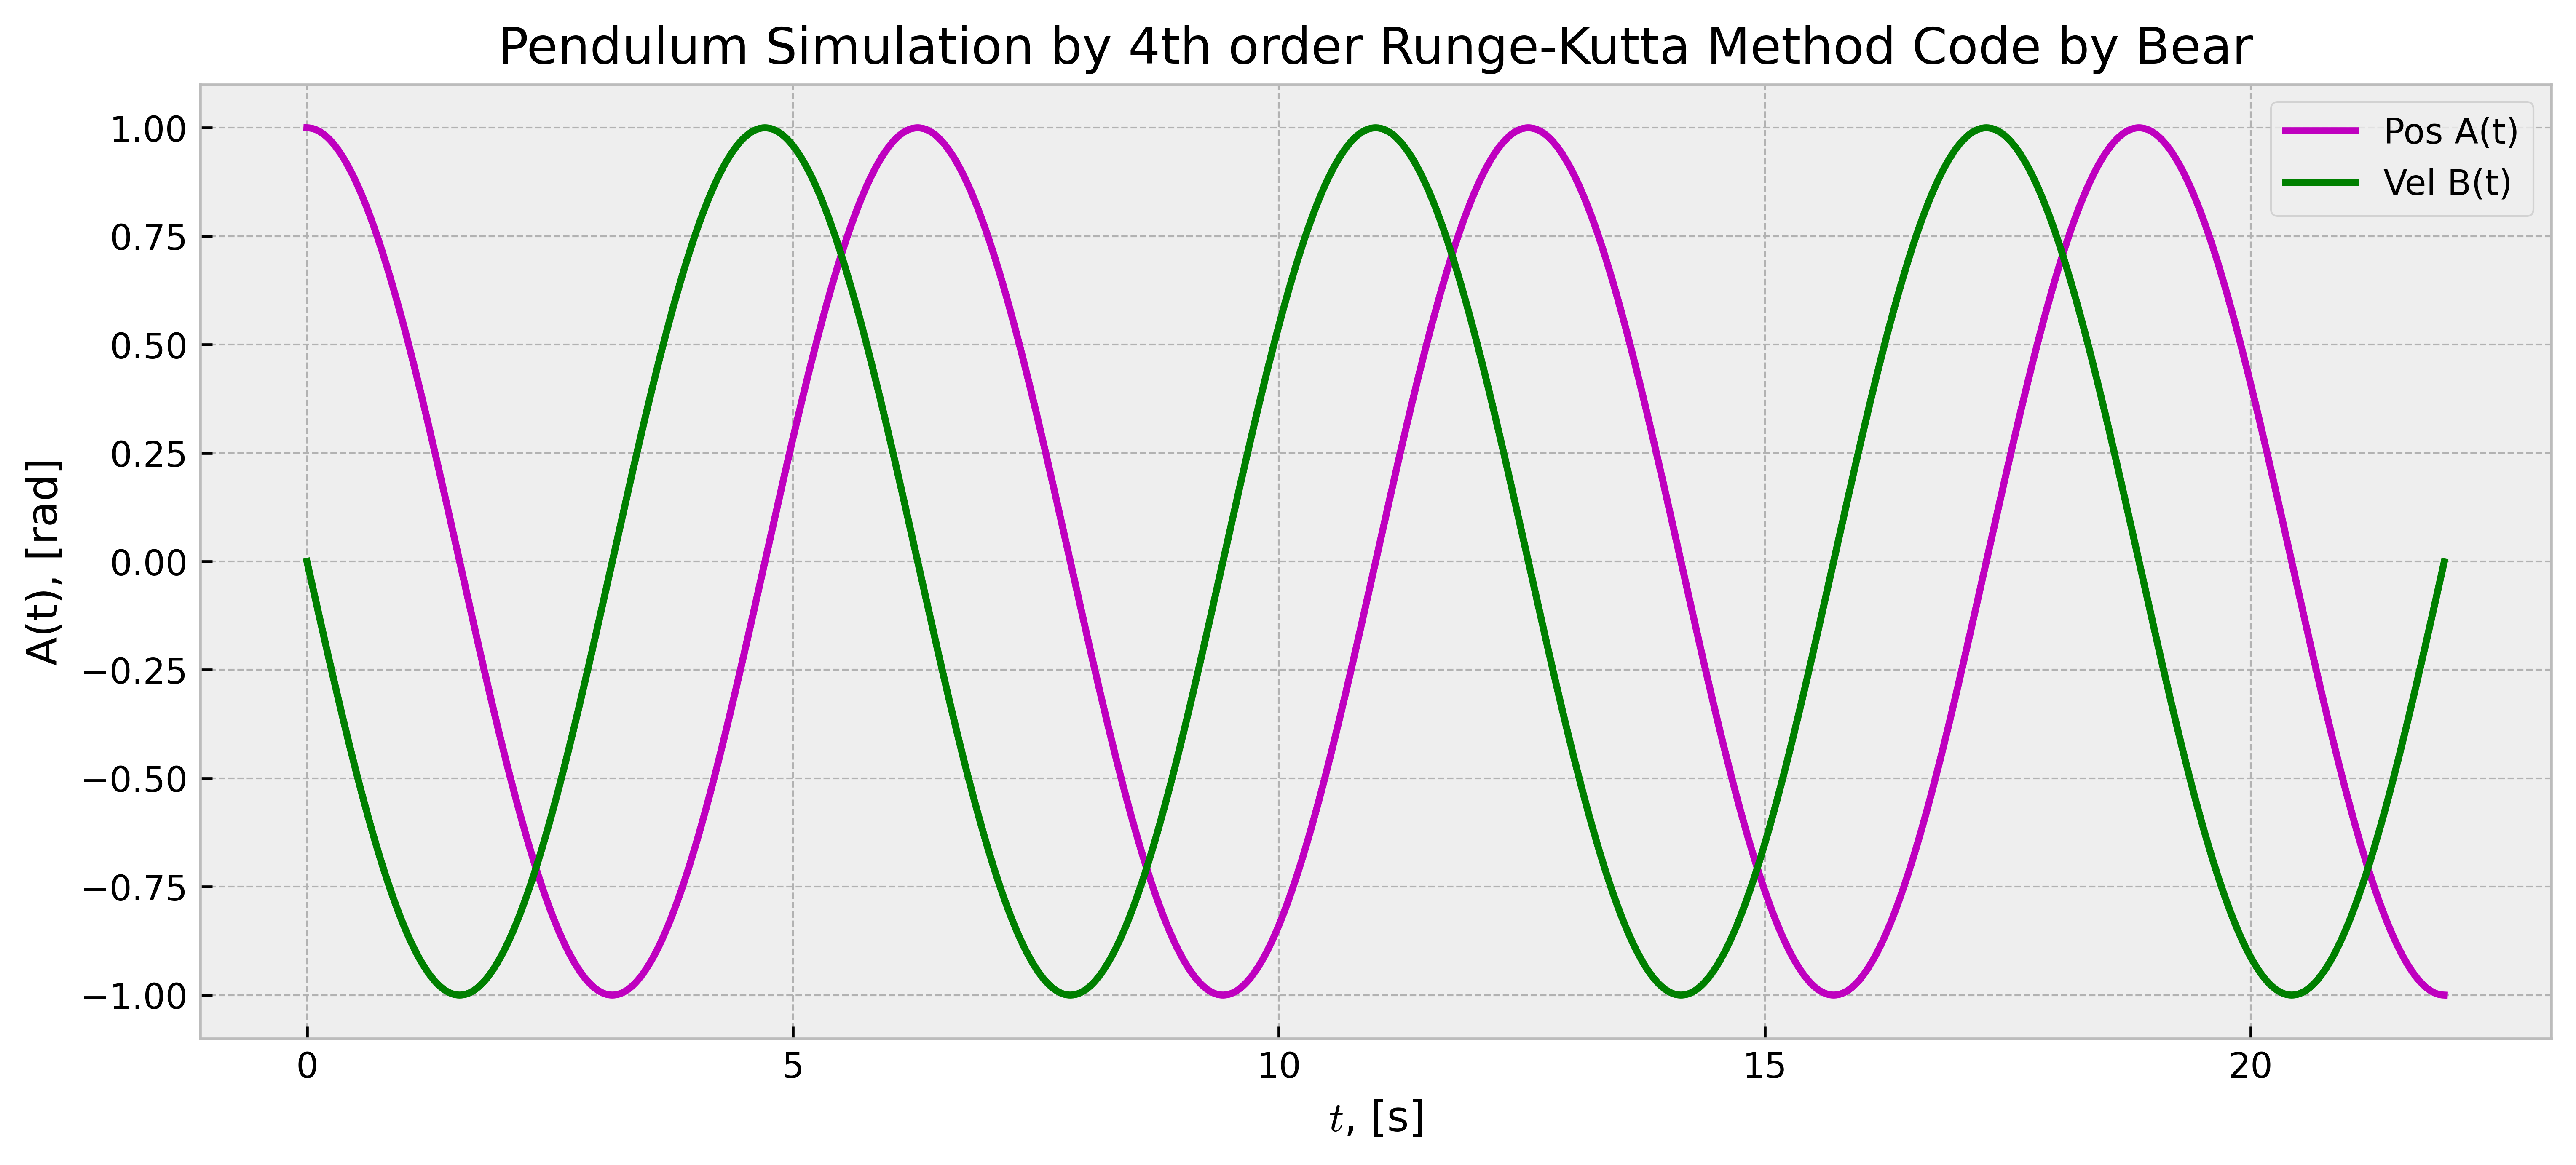

In [30]:
LB.show()

### 4.3.2 阻尼振动

In [31]:
LB=P4LB(L=10, g=10, A0=1, B0=0, dt=0.01, T=22, C=[[0,-1,0],[0,-0.5,0],[0,0,0]])

In [32]:
LB.RK_LB()

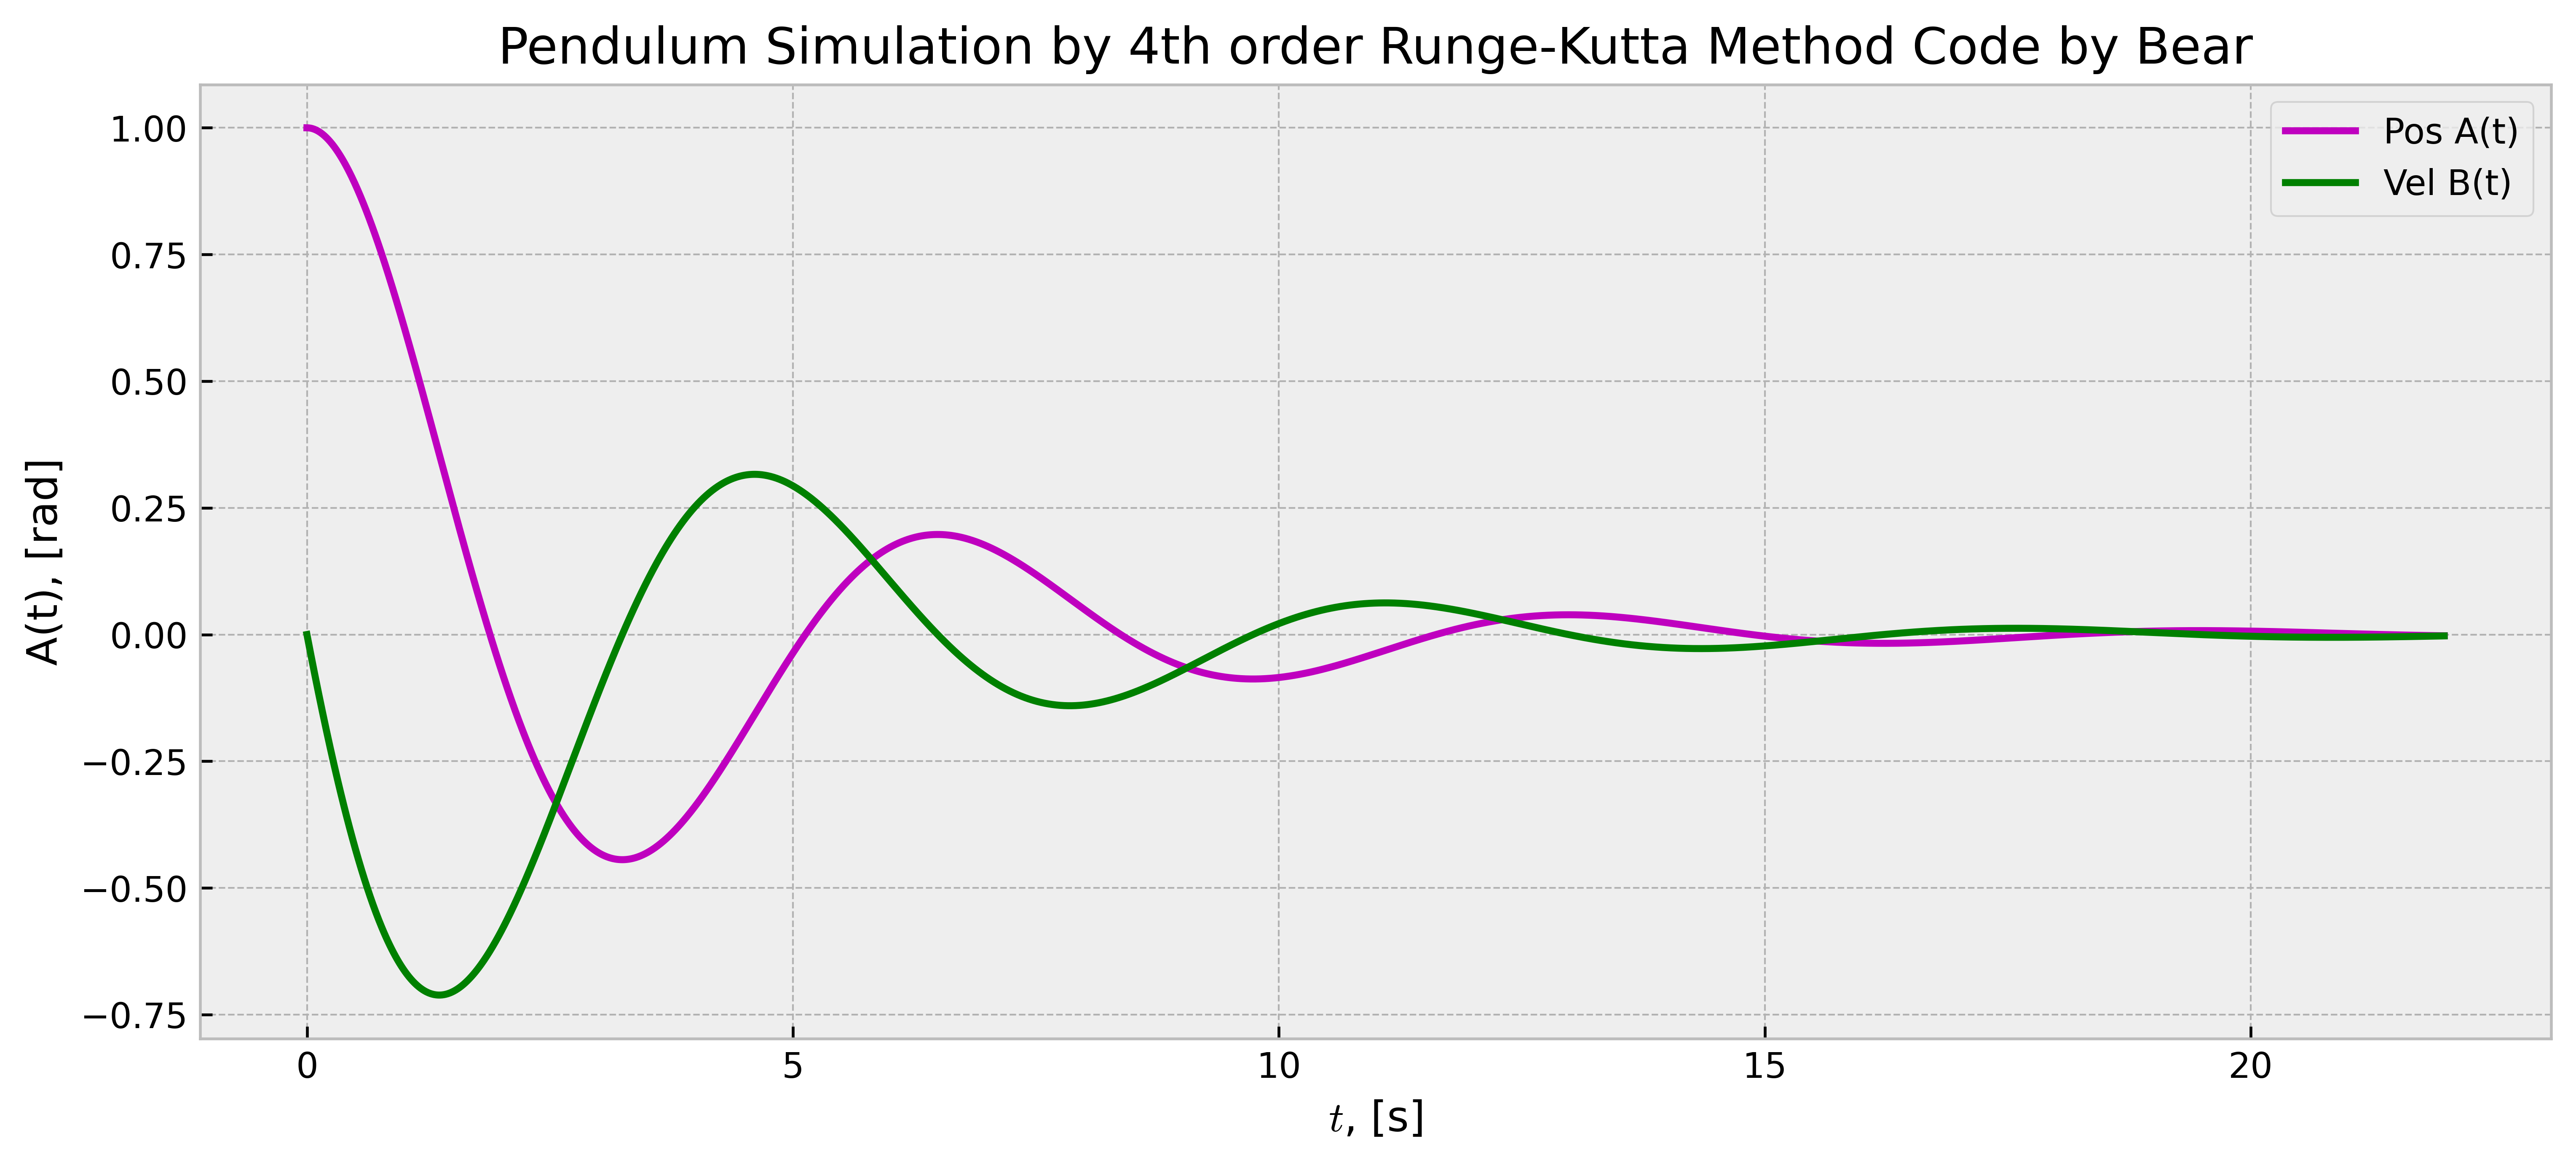

In [33]:
LB.show()

### 结果完全符合条件！

### 4.3.3 任意参数的振动

我们现在随机给一个系数矩阵，只要有这样的振动，我们就可以利用这个函数做出它的振动结果

如现在，我们给出系数矩阵为这样的一个振动：
<img style="float: middle;" src="4-4.png" width="22%">

In [34]:
LB=P4LB(L=10, g=10, A0=1, B0=0, dt=0.01, T=22, C=[[0.001,-1,0],[-0.005,0.1,0],[0.01,1,0]])

In [35]:
LB.RK_LB()

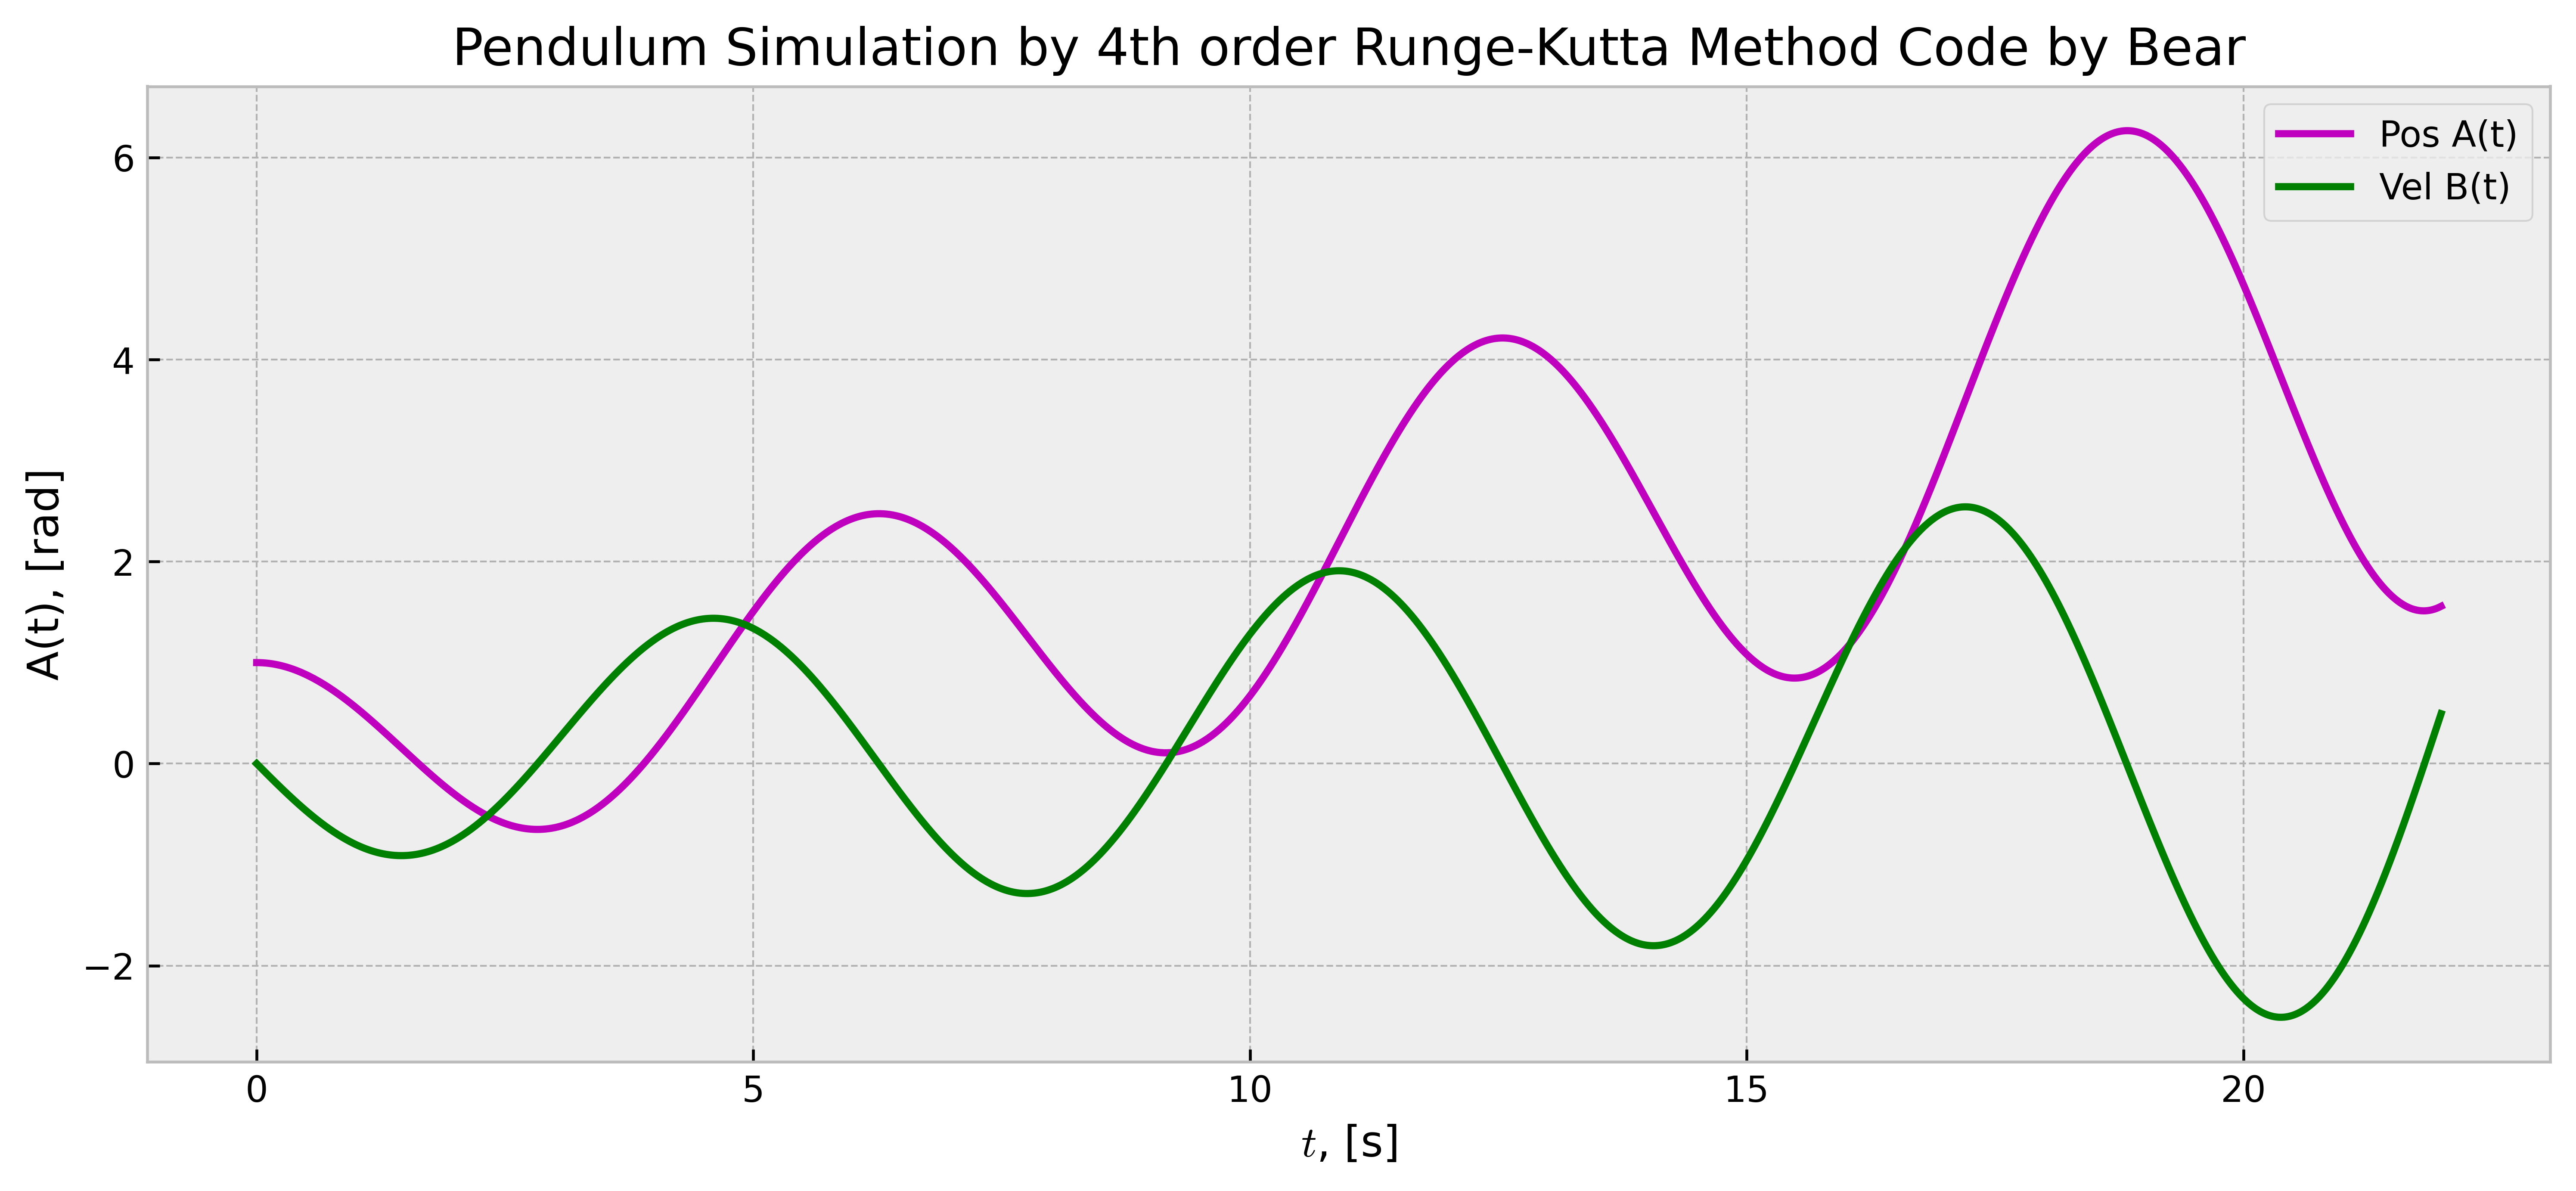

In [36]:
LB.show()

这样的振动就是一个往复的运动，可以从它的位置和速率看出来，这也算是振动的一类，但这个振动是发散的

### 4.4 结果讨论

我们可以非常大胆地得出结论，通过这次尝试。我们可以得出这样的结论：  
**我们已经解决了所有的一维振动问题**  
这个方法和最后一部分给出的类，可以非常直观且精准地解决几乎所有的单摆运动，只需要改正初值条件和系数矩阵就行；  
结果具有相当高的适用性，几乎能用来解决所有的一维振动问题，不仅仅是机械摆动，电磁振动。量子振动都可以用这个方法解决；  
得到的结果准确度非常高，在短时间内和解析解几乎没有差异；  
避免了复杂的数学计算，让研究者将主要精力花在物理原理和物理关系上，避免额外的计算；

但同时也有一些可以改善的地方：
1. 这个模型只能解决一维的问题，对于多维振动，如复摆等，需要利用一维模型进行二次建模；
2. 对于一些精度要求更高的振动，需要将类中的拟合进行三阶甚至更高阶拟合；